# EDA & Data Preparation.ipynb

# Group Assignment 4

For the dataset shared in Assignment-2, build and perform 2 rounds of empirical tuning on the following collaborative filtering recommender systems:

1. **Collaborative Filtering Recommender System**
   
2. **Collaborative Filtering Recommender System Using Clustering**
   - Utilize user and day-of-week (dow) combinations.

3. **Collaborative Filtering Recommender System Using Matrix Factorization**
   - Focus on cases where `add_to_cart_order < 5`.

4. **Collaborative Filtering Recommender System Using Matrix Factorization**
   
---

## Evaluation Criteria

Evaluate all the models on the following metrics:
- MAP@5
- Precision for 1000 random users/user/dow combinations

### Generalization Methods
- Use both strong and weak generalization methods for evaluation.

### Additional Task
- Identify the top product recommended for the top 5 users who buy the most "Bananas".

# MECE Table

| Team Member   | Contribution                                                                                      |
|---------------|---------------------------------------------------------------------------------------------------|
| Kauthara Oyinkansola Yakubu | - Data preprocessing and initial exploratory data analysis (EDA)                                   |
|               | - Identify top 5 users who buy the most "Bananas"                                                |
|               |                                                                                                   |
| Subhash Pavan Chakravarthy Somarouthu | - Implement collaborative filtering recommender system                                       |
|               | - Perform first round of empirical tuning for this system                                          |
|               |                                                                                                   |
| Watapotha Kosinnage Chalithya Sangeeth Kumarasinghe | - Perform second round of empirical tuning for collaborative filtering system                |
|               | - Evaluate each of the models on MAP@5 and Precision for 1000 random users/user, and dow combinations using strong and weak generalization |
|               |                                                                                                   |
| Abdullah Ifteqar Mohammed | - Implement collaborative filtering system using clustering with user and day-of-week combinations  |
|               | - Perform first round of empirical tuning for this clustered system                                 |
|               |                                                                                                   |
| Clifford Addison | - Perform second round of empirical tuning for clustered collaborative filtering system            |
|               | - Evaluate each of the models on MAP@5 and Precision for 1000 random users/user, and dow combinations using strong and weak generalization |
|               |                                                                                                   |
| Shanaz Palakunnil Moosa | - Implement matrix factorization-based collaborative filtering system for add_to_cart_order < 5  |
|               | - Perform first round of empirical tuning for this system                                          |
|               |                                                                                                   |
| Mansi Jayeshbai Sutreja | - Perform second round of empirical tuning for matrix factorization system (add_to_cart_order < 5)|
|               | - Proper documentation, ensuring everyone's work is running sequentially and all tasks are completed—submission of Assignment. |
|               |                                                                                                   |
| Aparna Jayakumar Resmi | - Implement general matrix factorization-based collaborative filtering system                      |
|               | - Perform first round of empirical tuning for this system                                          |
|               |                                                                                                   |
| Obianuju Nonyerem Anuma | - Perform second round of empirical tuning for general matrix factorization system                 |
|               | - Evaluate each of the models on MAP@5 and Precision for 1000 random users/user, and dow combinations using strong and weak generalization |
|               |                                                                                                   |
| Saurav Risal | - Identify top product recommended for the top 5 "Banana" buyers across all models                |
|               | - Evaluate this system on MAP@5 and Precision for 1000 random users/user, and dow combinations using strong and weak generalization |

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt#For visualizations
import itertools
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler#for Scalling feature datas
from sklearn.impute import KNNImputer, SimpleImputer#for handling missing data

# Importing libraries for modelling and evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Importing libraries for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split#For train and test dataset splitting

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
# Load the initial datasets
aisles_retail = pd.read_csv('/content/aisles.csv')
departments_retail = pd.read_csv('/content/departments.csv')
products_retail = pd.read_csv('/content/products.csv')
orders_df = pd.read_csv('/content/orders.csv')
order_products_retail = pd.read_csv('/content/order_products.csv')

print("Initial data loaded.")
print(f"aisles_retail shape: {aisles_retail.shape}")
print(f"departments_retail shape: {departments_retail.shape}")
print(f"products_retail shape: {products_retail.shape}")
print(f"orders_df shape: {orders_df.shape}")
print(f"order_products_retail shape: {order_products_retail.shape}")

Initial data loaded.
aisles_retail shape: (134, 2)
departments_retail shape: (21, 2)
products_retail shape: (49688, 4)
orders_df shape: (3421083, 7)
order_products_retail shape: (32434489, 4)


In [ ]:
# 1. Join products with aisles and departments
merged_products = products_retail.merge(aisles_retail, on='aisle_id', how='left').merge(departments_retail, on='department_id', how='left')

print("Products merged with aisles and departments.")
print(f"merged_products shape: {merged_products.shape}")

Products merged with aisles and departments.
merged_products shape: (49688, 6)


In [ ]:
merged_products.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


 Sampling 100,000 orders from Oders dataset because it has a Large Dataset

In [ ]:
# Sampling  orders_df
sample_fraction = 0.01  # 1% of the orders dataset
orders_sample = orders_df.sample(frac=sample_fraction, random_state=42)

print("Orders sampled.")
print(f"orders_sample shape: {orders_sample.shape}")

# Prepare for chunked processing
chunk_size = 1000000
result_chunks = []

print("Prepared for chunked processing.")

Orders sampled.
orders_sample shape: (34211, 7)
Prepared for chunked processing.


In [ ]:
# Process order_products_retail in chunks
for chunk in pd.read_csv('/content/order_products.csv', chunksize=chunk_size):
    # Merge chunk with merged_products
    chunk_with_products = chunk.merge(merged_products, on='product_id', how='left')

    # Merge with orders_sample
    merged_chunk = orders_sample.merge(chunk_with_products, on='order_id', how='inner')

    # Append the result to our list
    result_chunks.append(merged_chunk)

print("Chunked processing completed.")

Chunked processing completed.


In [ ]:
# Concatenate all the chunks
retail_dataset = pd.concat(result_chunks, ignore_index=True)

In [ ]:
retail_dataset.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,32608,66630,prior,2,1,9,30.0,42803,1,0,Organic Apple Slices,50,19,fruit vegetable snacks,snacks
1,86849,162135,prior,39,3,11,3.0,13707,1,1,Essential Red,28,5,red wines,alcohol
2,86849,162135,prior,39,3,11,3.0,44097,2,1,Organic Original Hummus,67,20,fresh dips tapenades,deli
3,86849,162135,prior,39,3,11,3.0,31720,3,1,Organic Whole Milk,84,16,milk,dairy eggs
4,86849,162135,prior,39,3,11,3.0,12099,4,1,Honey Greek Yogurt,120,16,yogurt,dairy eggs


In [ ]:
retail_dataset.tail()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
325634,3388100,76191,prior,1,1,10,NaN,17794,4,0,Carrots,83,4,fresh vegetables,produce
325635,3388100,76191,prior,1,1,10,NaN,42719,5,0,Natural Premium Coconut Water,98,7,juice nectars,beverages
325636,3388100,76191,prior,1,1,10,NaN,31506,6,0,Extra Virgin Olive Oil,19,13,oils vinegars,pantry
325637,3388100,76191,prior,1,1,10,NaN,18564,7,0,Diet Ginger Ale All Natural Soda,77,7,soft drinks,beverages
325638,3388100,76191,prior,1,1,10,NaN,4562,8,0,English Seedless Cucumber,83,4,fresh vegetables,produce


In [ ]:
retail_dataset.shape

(325639, 15)

In [ ]:
# Create a copy before grouping
retail_dataset_copy = retail_dataset.copy()

print("Shape before grouping:", retail_dataset_copy.shape)

# Group by user_id, product_id, and order_id
groupby_columns = ['user_id', 'product_id', 'order_id']

# Aggregate the data
updated_retail = retail_dataset_copy.groupby(groupby_columns).agg({
    'add_to_cart_order': 'min',
    'reordered': 'max',
    'order_number': 'first',
    'order_dow': 'first',
    'order_hour_of_day': 'first',
    'days_since_prior_order': 'first',
    'product_name': 'first',
    'aisle_id': 'first',
    'department_id': 'first',
    'aisle': 'first',
    'department': 'first'
}).reset_index()

# Add new columns for additional information
updated_retail['interaction_count'] = updated_retail.groupby(['user_id', 'product_id'])['order_id'].transform('count')
updated_retail['total_orders'] = updated_retail.groupby('user_id')['order_id'].transform('nunique')
updated_retail['product_order_rate'] = updated_retail['interaction_count'] / updated_retail['total_orders']

print("Shape after grouping:", updated_retail.shape)

Shape before grouping: (325639, 15)
Shape after grouping: (325639, 17)


# Additional columns added:  Added three new columns to the dataset after grouping:

a) **interaction_count:**This column counts how many times each user-product combination appears in the dataset. It helps identify frequently purchased products for each user.

b) **total_orders:** This column counts the unique orders for each user. It gives an idea of how active each user is on the platform.

c) **product_order_rate:**  This is calculated as interaction_count / total_orders. It represents the proportion of a user's orders that include a specific product, indicating how frequently a user buys a particular product relative to their overall purchasing behavior.

In [ ]:
# To confirm all features are present
print("Columns in the updated retail dataset:")
print(updated_retail.columns)

Columns in the updated retail dataset:
Index(['user_id', 'product_id', 'order_id', 'add_to_cart_order', 'reordered', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_name', 'aisle_id',
       'department_id', 'aisle', 'department', 'interaction_count', 'total_orders',
       'product_order_rate'],
      dtype='object')


In [ ]:
updated_retail.head()

,user_id,product_id,order_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department,interaction_count,total_orders,product_order_rate
0,24,46473,1869748,1,0,2,6,16,3.0,Pure Vanilla Extract,17,13,baking ingredients,pantry,1,1,1.0
1,27,1194,3094422,2,1,50,4,14,1.0,Natural Artisan Water,115,7,water seltzer sparkling water,beverages,1,2,0.5
2,27,4920,1225000,1,1,72,1,13,7.0,Seedless Red Grapes,123,4,packaged vegetables fruits,produce,1,2,0.5
3,27,4957,1225000,4,1,72,1,13,7.0,Total 2% Lowfat Greek Strained Yogurt With Blueberry,120,16,yogurt,dairy eggs,1,2,0.5
4,27,8385,3094422,7,0,50,4,14,1.0,Sliced Genoa Salami,96,20,lunch meat,deli,1,2,0.5


In [ ]:
updated_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325639 entries, 0 to 325638
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 325639 non-null  int64  
 1   product_id              325639 non-null  int64  
 2   order_id                325639 non-null  int64  
 3   add_to_cart_order       325639 non-null  int64  
 4   reordered               325639 non-null  int64  
 5   order_number            325639 non-null  int64  
 6   order_dow               325639 non-null  int64  
 7   order_hour_of_day       325639 non-null  int64  
 8   days_since_prior_order  304654 non-null  float64
 9   product_name            325639 non-null  object 
 10  aisle_id                325639 non-null  int64  
 11  department_id           325639 non-null  int64  
 12  aisle                   325639 non-null  object 
 13  department              325639 non-null  object 
 14  interaction_count   

In [ ]:
updated_retail.describe()

,user_id,product_id,order_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,interaction_count,total_orders,product_order_rate
count,325639.000000,325639.000000,3.256390e+05,325639.000000,325639.000000,325639.000000,325639.000000,325639.000000,304654.000000,325639.000000,325639.000000,325639.000000,325639.000000,325639.000000
mean,103340.734958,25611.572392,1.712946e+06,8.378772,0.590344,17.195483,2.729664,13.435482,11.021539,71.220367,9.956694,1.067037,1.323386,0.891154
std,59450.446643,14082.803763,9.848002e+05,7.196670,0.491771,17.676522,2.093902,4.229648,8.725285,38.234583,6.287835,0.281491,0.627070,0.215804
min,24.000000,1.000000,4.700000e+01,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.166667
25%,51762.000000,13575.000000,8.653755e+05,3.000000,0.000000,5.000000,1.000000,10.000000,5.000000,31.000000,4.000000,1.000000,1.000000,1.000000
50%,103172.000000,25407.000000,1.711391e+06,6.000000,1.000000,11.000000,3.000000,13.000000,8.000000,83.000000,9.000000,1.000000,1.000000,1.000000
75%,155017.000000,37919.000000,2.564511e+06,11.000000,1.000000,24.000000,5.000000,16.000000,15.000000,107.000000,16.000000,1.000000,2.000000,1.000000
max,206207.000000,49686.000000,3.421035e+06,99.000000,1.000000,99.000000,6.000000,23.000000,30.000000,134.000000,21.000000,6.000000,6.000000,1.000000


## Checking for any Data Inconsistencies

In [ ]:
# 1. Checking for any null values resulting from the merge
print("\nNull value counts:")
print(updated_retail.isnull().sum())


Null value counts:
user_id                       0
product_id                    0
order_id                      0
add_to_cart_order             0
reordered                     0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    20985
product_name                  0
aisle_id                      0
department_id                 0
aisle                         0
department                    0
interaction_count             0
total_orders                  0
product_order_rate            0
dtype: int64


In [ ]:
# 2. Checking for unique values
for i in updated_retail.columns:
    print(updated_retail[i].value_counts())

user_id
5360      200
95967     152
97362     123
80527     115
193014    106
         ... 
26670       1
26756       1
94067       1
26850       1
24          1
Name: count, Length: 27760, dtype: int64
product_id
24852    4853
13176    3747
21137    2720
21903    2406
47209    2155
         ... 
25236       1
257         1
10067       1
38637       1
46640       1
Name: count, Length: 25480, dtype: int64
order_id
2716231    99
1386261    91
2804898    84
596253     72
2423399    68
           ..
299274      1
3253957     1
787262      1
2538274     1
1869748     1
Name: count, Length: 32195, dtype: int64
add_to_cart_order
1     32195
2     30679
3     28858
4     26758
5     24569
      ...  
95        1
94        1
97        1
92        1
96        1
Name: count, Length: 99, dtype: int64
reordered
1    192239
0    133400
Name: count, dtype: int64
order_number
2     21294
1     20985
3     20108
4     17962
5     16426
      ...  
93      154
98      134
89      124
96      104
99    

In [ ]:
# 3. Checking for negative values in numeric columns
print("\n3. Checking for negative values in numeric columns...")
numeric_columns = updated_retail.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    negative_count = (updated_retail[col] < 0).sum()
    if negative_count > 0:
        print(f"  Column '{col}' has {negative_count} negative values.")
print("Negative value check completed.")


3. Checking for negative values in numeric columns...
Negative value check completed.


In [ ]:
# 4. Checking for out-of-range values
print("\n4. Checking for out-of-range values...")
if 'order_dow' in updated_retail.columns:
    invalid_dow = (updated_retail['order_dow'] < 0) | (updated_retail['order_dow'] > 6)
    print(f"  Invalid day of week values: {invalid_dow.sum()}")

if 'order_hour_of_day' in updated_retail.columns:
    invalid_hour = (updated_retail['order_hour_of_day'] < 0) | (updated_retail['order_hour_of_day'] > 23)
    print(f"  Invalid hour of day values: {invalid_hour.sum()}")
print("Out-of-range value check completed.")


4. Checking for out-of-range values...
  Invalid day of week values: 0
  Invalid hour of day values: 0
Out-of-range value check completed.


In [ ]:
# 5.  Checking for inconsistent categorical data
print("\n5. Checking for inconsistent categorical data...")
categorical_columns = updated_retail.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_values = updated_retail[col].nunique()
    print(f"  Column '{col}' has {unique_values} unique values.")

    if unique_values > 100:  # Adjust this threshold as needed
        print(f"  Warning: High number of unique values in '{col}'. May need further investigation.")
        print(f"  Top 10 most common values in '{col}':")
        print(updated_retail[col].value_counts().head(10))
    else:
        print(f"  All unique values in '{col}':")
        print(updated_retail[col].unique())

    print()

print("Categorical data check completed.")


5. Checking for inconsistent categorical data...
  Column 'product_name' has 25480 unique values.
  Top 10 most common values in 'product_name':
product_name
Banana                    4853
Bag of Organic Bananas    3747
Organic Strawberries      2720
Organic Baby Spinach      2406
Organic Hass Avocado      2155
Organic Avocado           1787
Large Lemon               1555
Strawberries              1438
Limes                     1413
Organic Raspberries       1390
Name: count, dtype: int64

  Column 'aisle' has 134 unique values.
  Top 10 most common values in 'aisle':
aisle
fresh fruits                     36670
fresh vegetables                 34101
packaged vegetables fruits       17697
yogurt                           14753
packaged cheese                   9821
milk                              8857
water seltzer sparkling water     8453
chips pretzels                    7414
soy lactosefree                   6408
bread                             5827
Name: count, dtype: int64

 

In [ ]:
# 6. Checking for unique value in department column

unique_departments = updated_retail['department'].nunique()
print(f"  The 'department' column has {unique_departments} unique values.")

# Get value counts and sort by frequency
dept_counts = updated_retail['department'].value_counts().sort_values(ascending=False)

print("\n  All departments and their frequencies:")
for dept, count in dept_counts.items():
    print(f"  {dept}: {count}")

  The 'department' column has 21 unique values.

  All departments and their frequencies:
  produce: 94989
  dairy eggs: 54485
  snacks: 29447
  beverages: 26742
  frozen: 22068
  pantry: 18712
  bakery: 11859
  canned goods: 10999
  deli: 10749
  dry goods pasta: 8774
  household: 7312
  breakfast: 7094
  meat seafood: 6981
  personal care: 4464
  babies: 4240
  international: 2656
  alcohol: 1600
  pets: 1010
  missing: 707
  other: 392
  bulk: 359


In [ ]:
# Checking for null value in 'department' column
null_count = updated_retail['department'].isnull().sum()
total_records = len(updated_retail)
null_percentage = (null_count / total_records) * 100

print(f"  Null values in 'department' column: {null_count} ({null_percentage:.2f}%)")

  Null values in 'department' column: 0 (0.00%)


In [ ]:
# Checking categorical data for 'aisle' colum
print(" Checking categorical data for 'aisle' column...")

# Check for null values
null_count = updated_retail['aisle'].isnull().sum()
total_records = len(updated_retail)
null_percentage = (null_count / total_records) * 100

print(f"  Null values in 'aisle' column: {null_count} ({null_percentage:.2f}%)")

# Count unique values (excluding nulls)
unique_aisles = updated_retail['aisle'].nunique()
print(f"  The 'aisle' column has {unique_aisles} unique values (excluding nulls).")

# Get value counts and sort by frequency (this will automatically exclude nulls)
aisle_counts = updated_retail['aisle'].value_counts().sort_values(ascending=False)

print("\n  Top 20 aisles and their frequencies:")
for aisle, count in aisle_counts.head(20).items():
    print(f"  {aisle}: {count}")

# Calculate and display percentages for top 20
print("\n  Top 20 aisles by percentage (including nulls in total count):")
for aisle, count in aisle_counts.head(20).items():
    percentage = (count / total_records) * 100
    print(f"  {aisle}: {percentage:.2f}%")

# If there are null values, add them to the percentage list
if null_count > 0:
    print(f"  Null: {null_percentage:.2f}%")

print(f"\n  Total number of aisles: {len(aisle_counts)}")

print("\nAisle data check completed.")

 Checking categorical data for 'aisle' column...
  Null values in 'aisle' column: 0 (0.00%)
  The 'aisle' column has 134 unique values (excluding nulls).

  Top 20 aisles and their frequencies:
  fresh fruits: 36670
  fresh vegetables: 34101
  packaged vegetables fruits: 17697
  yogurt: 14753
  packaged cheese: 9821
  milk: 8857
  water seltzer sparkling water: 8453
  chips pretzels: 7414
  soy lactosefree: 6408
  bread: 5827
  refrigerated: 5799
  frozen produce: 5233
  ice cream ice: 4887
  crackers: 4673
  energy granola bars: 4640
  eggs: 4522
  lunch meat: 4016
  baby food formula: 3852
  frozen meals: 3811
  cereal: 3764

  Top 20 aisles by percentage (including nulls in total count):
  fresh fruits: 11.26%
  fresh vegetables: 10.47%
  packaged vegetables fruits: 5.43%
  yogurt: 4.53%
  packaged cheese: 3.02%
  milk: 2.72%
  water seltzer sparkling water: 2.60%
  chips pretzels: 2.28%
  soy lactosefree: 1.97%
  bread: 1.79%
  refrigerated: 1.78%
  frozen produce: 1.61%
  ice crea

In [ ]:
# 7. Check for duplicate rows after grouping
print("\n7. Checking for duplicate rows after grouping...")
duplicate_rows = updated_retail.duplicated().sum()
print(f"  Number of duplicate rows after grouping: {duplicate_rows}")
print("Duplicate row check completed.")


7. Checking for duplicate rows after grouping...
  Number of duplicate rows after grouping: 0
Duplicate row check completed.


In [ ]:
# 8. Checking for inconsistencies in user ID or product IDs
print("\n8. Checking for inconsistencies in user IDs...")
user_order_counts = updated_retail.groupby('user_id')['order_id'].nunique()
suspicious_users = user_order_counts[user_order_counts > 100]  # Adjust threshold as needed
if not suspicious_users.empty:
    print(f"  Users with suspiciously high number of orders: {len(suspicious_users)}")
    print("  Top 5 suspicious users:")
    print(suspicious_users.head())
else:
    print("  No users with suspiciously high number of orders found.")
print("User ID consistency check completed.")


8. Checking for inconsistencies in user IDs...
  No users with suspiciously high number of orders found.
User ID consistency check completed.


In [ ]:
# 9. Check for missing values
print("\n9. Checking for missing values...")
missing_values = updated_retail.isnull().sum()
print("  Missing values in each column:")
print(missing_values)
print("Missing value check completed.")


9. Checking for missing values...
  Missing values in each column:
user_id                       0
product_id                    0
order_id                      0
add_to_cart_order             0
reordered                     0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    20985
product_name                  0
aisle_id                      0
department_id                 0
aisle                         0
department                    0
interaction_count             0
total_orders                  0
product_order_rate            0
dtype: int64
Missing value check completed.


In [ ]:
# 10. Check for outliers in numeric columns (using IQR method)
print("\n10. Checking for outliers in numeric columns...")
for col in numeric_columns:
    Q1 = updated_retail[col].quantile(0.25)
    Q3 = updated_retail[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((updated_retail[col] < lower_bound) | (updated_retail[col] > upper_bound)).sum()
    if outliers > 0:
        print(f"  Column '{col}' has {outliers} potential outliers.")
print("Outlier check completed.")



10. Checking for outliers in numeric columns...
  Column 'add_to_cart_order' has 13809 potential outliers.
  Column 'order_number' has 18497 potential outliers.
  Column 'order_hour_of_day' has 2050 potential outliers.
  Column 'interaction_count' has 19501 potential outliers.
  Column 'total_orders' has 3780 potential outliers.
  Column 'product_order_rate' has 67843 potential outliers.
Outlier check completed.


In [ ]:

for col in ['add_to_cart_order', 'order_number', 'order_hour_of_day', 'interaction_count', 'total_orders', 'product_order_rate']:
    Q1 = updated_retail[col].quantile(0.25)
    Q3 = updated_retail[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = updated_retail[(updated_retail[col] < lower_bound) | (updated_retail[col] > upper_bound)]
    print(f"\nOutliers in {col}:")
    print(outliers[col].describe())



Outliers in add_to_cart_order:
count    13809.000000
mean        30.267072
std          7.513579
min         24.000000
25%         25.000000
50%         28.000000
75%         33.000000
max         99.000000
Name: add_to_cart_order, dtype: float64

Outliers in order_number:
count    18497.000000
mean        68.435963
std         12.199973
min         53.000000
25%         58.000000
50%         66.000000
75%         76.000000
max         99.000000
Name: order_number, dtype: float64

Outliers in order_hour_of_day:
count    2050.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: order_hour_of_day, dtype: float64

Outliers in interaction_count:
count    19501.000000
mean         2.119430
std          0.380879
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          6.000000
Name: interaction_count, dtype: float64

Outliers in total_orders:
count    3780.000000
mean        4.2359

In [ ]:
updated_retail.describe()

,user_id,product_id,order_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,interaction_count,total_orders,product_order_rate
count,325639.000000,325639.000000,3.256390e+05,325639.000000,325639.000000,325639.000000,325639.000000,325639.000000,304654.000000,325639.000000,325639.000000,325639.000000,325639.000000,325639.000000
mean,103340.734958,25611.572392,1.712946e+06,8.378772,0.590344,17.195483,2.729664,13.435482,11.021539,71.220367,9.956694,1.067037,1.323386,0.891154
std,59450.446643,14082.803763,9.848002e+05,7.196670,0.491771,17.676522,2.093902,4.229648,8.725285,38.234583,6.287835,0.281491,0.627070,0.215804
min,24.000000,1.000000,4.700000e+01,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.166667
25%,51762.000000,13575.000000,8.653755e+05,3.000000,0.000000,5.000000,1.000000,10.000000,5.000000,31.000000,4.000000,1.000000,1.000000,1.000000
50%,103172.000000,25407.000000,1.711391e+06,6.000000,1.000000,11.000000,3.000000,13.000000,8.000000,83.000000,9.000000,1.000000,1.000000,1.000000
75%,155017.000000,37919.000000,2.564511e+06,11.000000,1.000000,24.000000,5.000000,16.000000,15.000000,107.000000,16.000000,1.000000,2.000000,1.000000
max,206207.000000,49686.000000,3.421035e+06,99.000000,1.000000,99.000000,6.000000,23.000000,30.000000,134.000000,21.000000,6.000000,6.000000,1.000000


In [ ]:
# 11. Check for inconsistencies between related columns
print("\n11. Checking for inconsistencies between related columns...")
if 'reordered' in updated_retail.columns and 'order_number' in updated_retail.columns:
    inconsistent = ((updated_retail['reordered'] == 1) & (updated_retail['order_number'] == 1)).sum()
    if inconsistent > 0:
        print(f"  Inconsistency: {inconsistent} products marked as reordered in first order.")
    else:
        print("  No inconsistencies found between 'reordered' and 'order_number' columns.")
else:
    print("  'reordered' or 'order_number' column not found. Skipping this check.")
print("Related column consistency check completed.")

print("\nData error checking process completed.")


11. Checking for inconsistencies between related columns...
  No inconsistencies found between 'reordered' and 'order_number' columns.
Related column consistency check completed.

Data error checking process completed.


# Visualization of Exploratory Data Analysis on the Entire Dataset

1. **Percentange Of Missing Value**

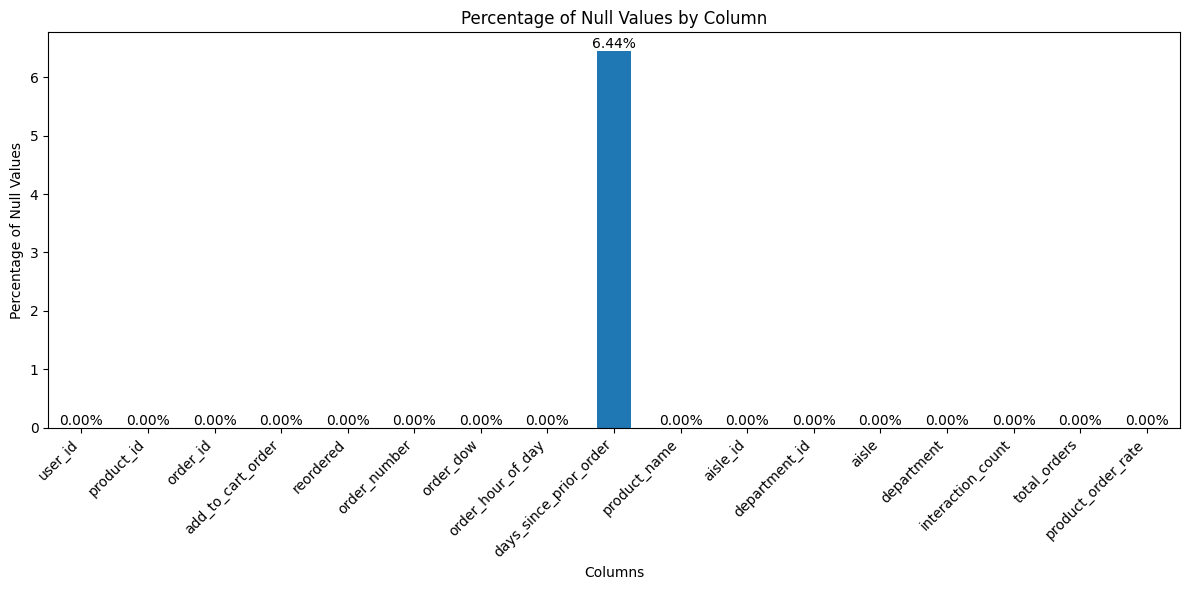

user_id                   0.000000
product_id                0.000000
order_id                  0.000000
add_to_cart_order         0.000000
reordered                 0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.444253
product_name              0.000000
aisle_id                  0.000000
department_id             0.000000
aisle                     0.000000
department                0.000000
interaction_count         0.000000
total_orders              0.000000
product_order_rate        0.000000
dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Calculate percentage of null values for each column
null_percentages = updated_retail.isnull().mean() * 100

# Create a bar chart
plt.figure(figsize=(12, 6))
null_percentages.plot(kind='bar')
plt.title('Percentage of Null Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add percentage labels on top of each bar
for i, v in enumerate(null_percentages):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')

# Show the plot
plt.show()

# Print the percentages
print(null_percentages)

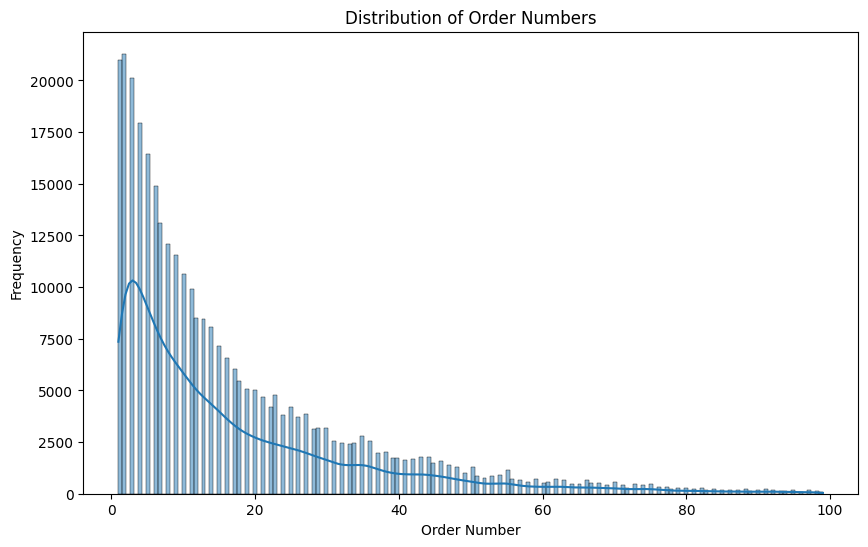

In [ ]:
# Histogram of order_number
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=updated_retail, x='order_number', kde=True)
plt.title('Distribution of Order Numbers')
plt.xlabel('Order Number')
plt.ylabel('Frequency')
plt.show()

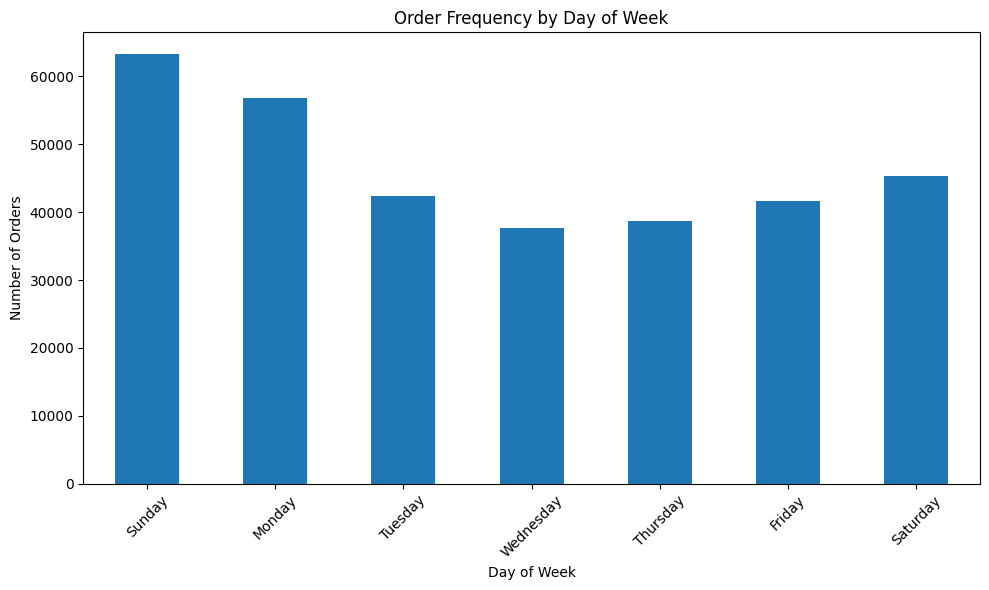

In [ ]:
# Visualizing Order frequency by day of week

# Creating a dictionary to map numeric days to day names
day_order = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
             4: 'Thursday', 5: 'Friday', 6: 'Saturday'}

# Count orders for each day and map to day names
day_counts = updated_retail['order_dow'].value_counts().sort_index()
day_counts.index = day_counts.index.map(day_order)

plt.figure(figsize=(10, 6))
day_counts.plot(kind='bar')
plt.title('Order Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

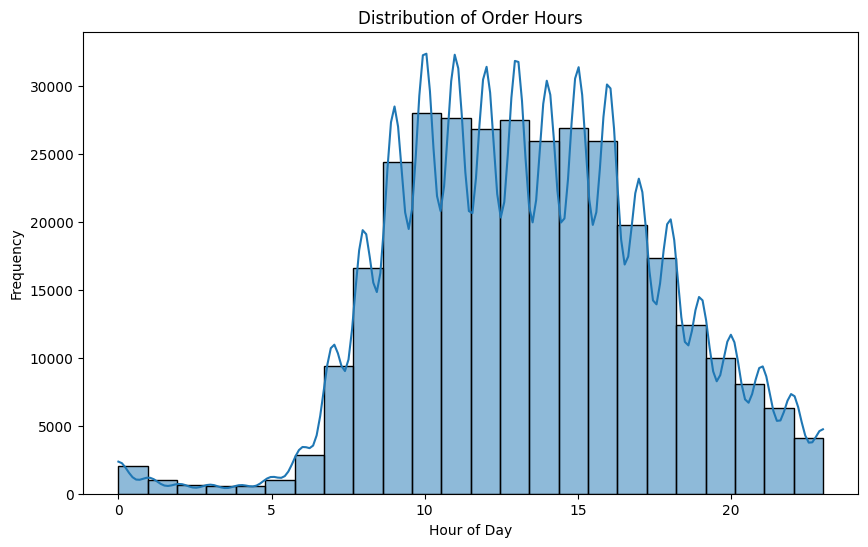

In [ ]:
# Histogram of order_hour_of_day
plt.figure(figsize=(10, 6))
sns.histplot(data=updated_retail, x='order_hour_of_day', kde=True, bins=24)
plt.title('Distribution of Order Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

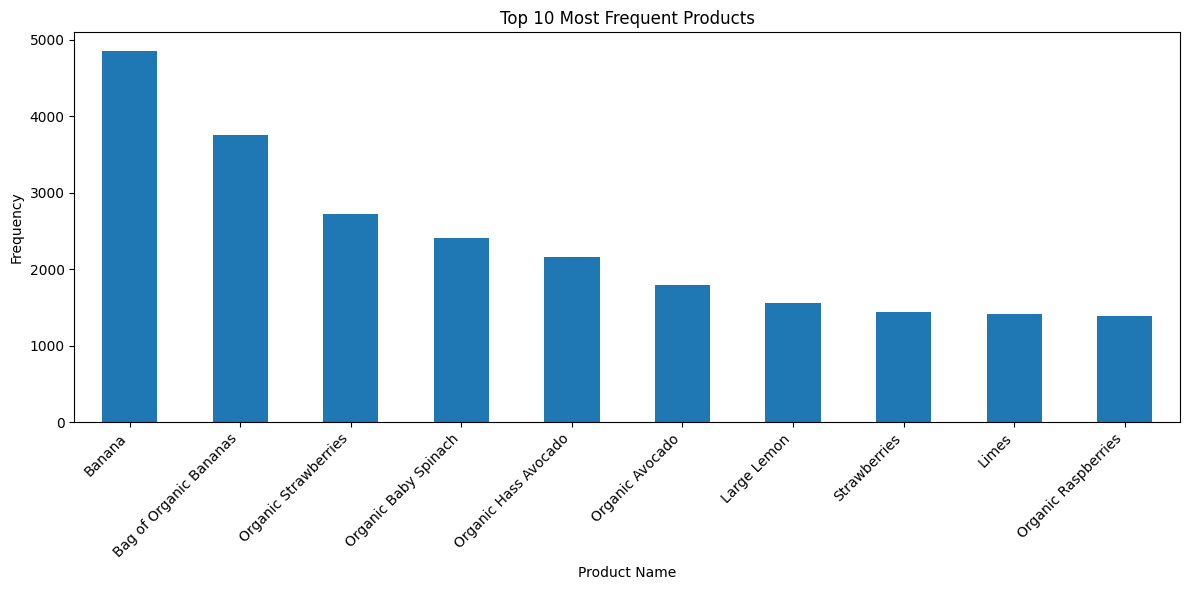

In [ ]:
# Visualizing Top 10 most frequent products
top_products = updated_retail['product_name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_products.plot(kind='bar')
plt.title('Top 10 Most Frequent Products')
plt.xlabel('Product Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

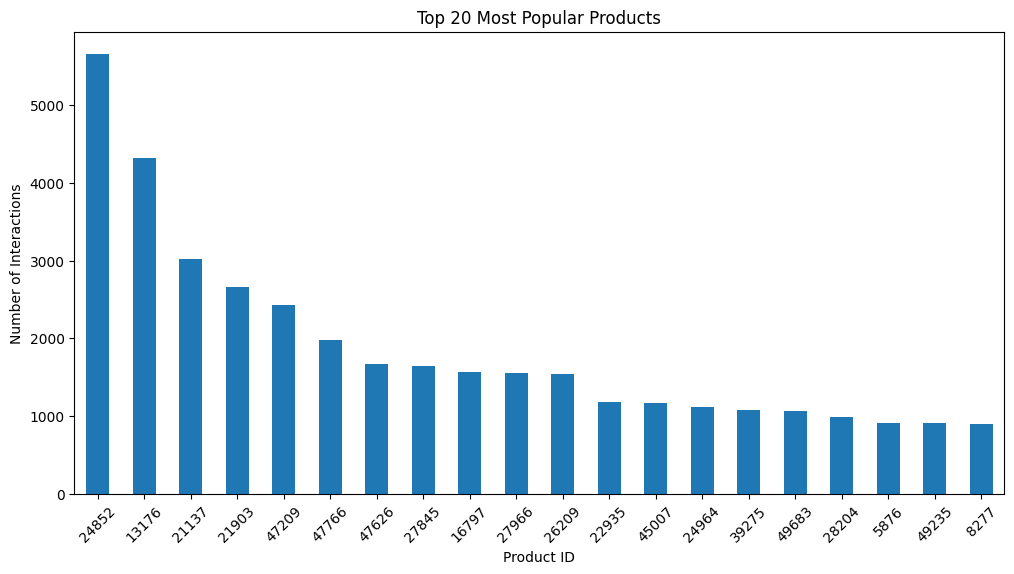

In [ ]:
# Product popularity distribution by Product ID
product_popularity = updated_retail.groupby('product_id')['interaction_count'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
product_popularity.head(20).plot(kind='bar')
plt.title('Top 20 Most Popular Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.show()

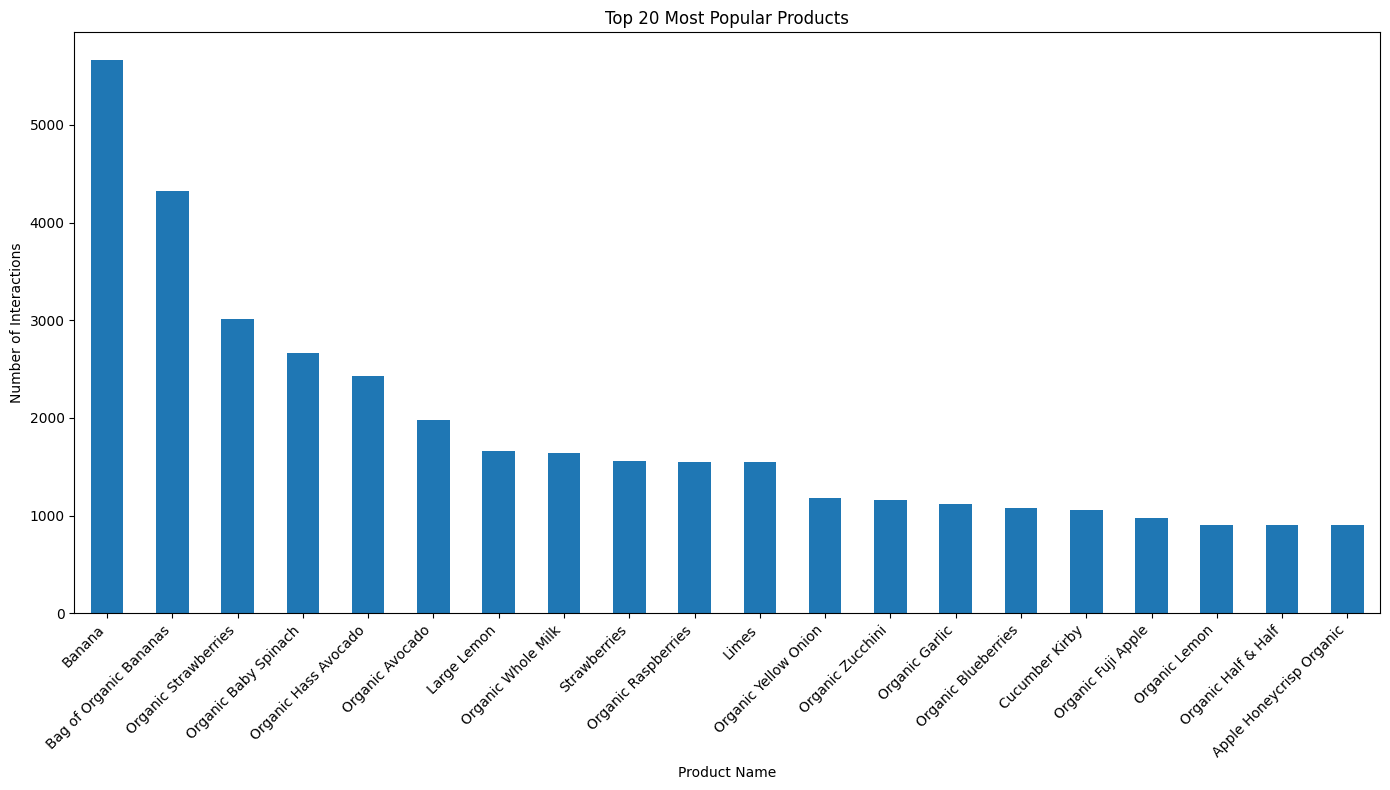

In [ ]:


# Assuming updated_retail is your DataFrame and it has been defined
product_popularity = updated_retail.groupby('product_name')['interaction_count'].sum().sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(14, 8))  # Increase the figure size
product_popularity.head(20).plot(kind='bar')

# Set titles and labels
plt.title('Top 20 Most Popular Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Interactions')

# Rotate x-ticks and align them
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

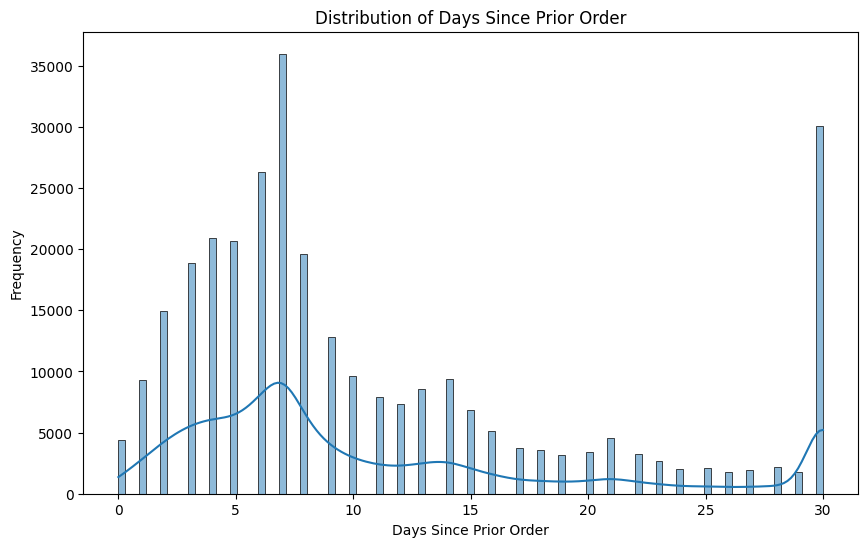

In [ ]:
# Histogram of days_since_prior_order
plt.figure(figsize=(10, 6))
sns.histplot(data=updated_retail, x='days_since_prior_order', kde=True)
plt.title('Distribution of Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Frequency')
plt.show()

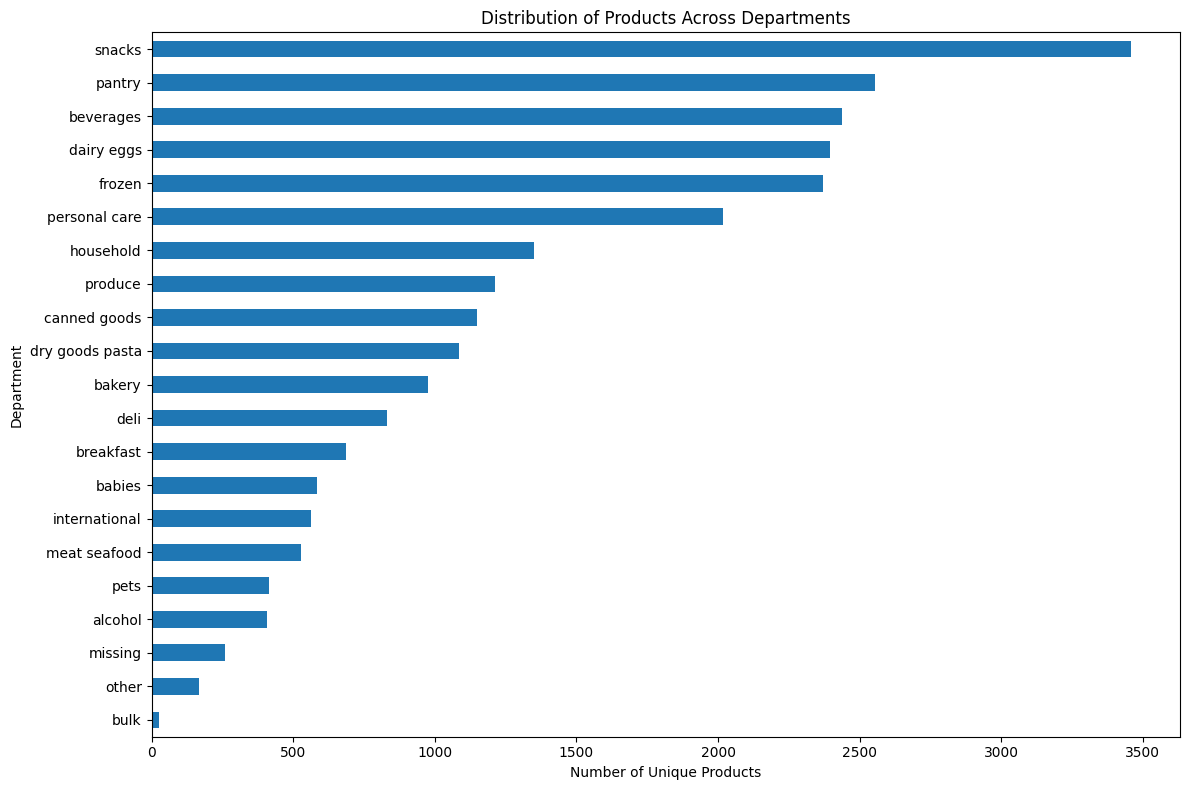

In [ ]:
#Distribution of products across departments
dept_product_counts = updated_retail.groupby('department')['product_id'].nunique().sort_values(ascending=True)
plt.figure(figsize=(12, 8))
dept_product_counts.plot(kind='barh', stacked=True)
plt.title('Distribution of Products Across Departments')
plt.xlabel('Number of Unique Products')
plt.ylabel('Department')
plt.tight_layout()
plt.show()

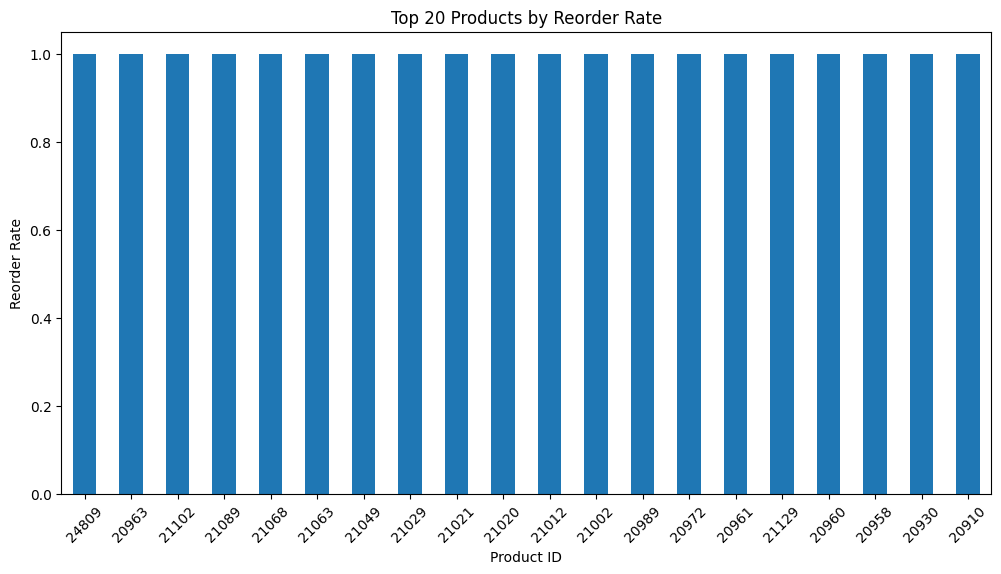

In [ ]:
# Reorder rates
reorder_rates = updated_retail.groupby('product_id')['reordered'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
reorder_rates.head(20).plot(kind='bar')
plt.title('Top 20 Products by Reorder Rate')
plt.xlabel('Product ID')
plt.ylabel('Reorder Rate')
plt.xticks(rotation=45)
plt.show()

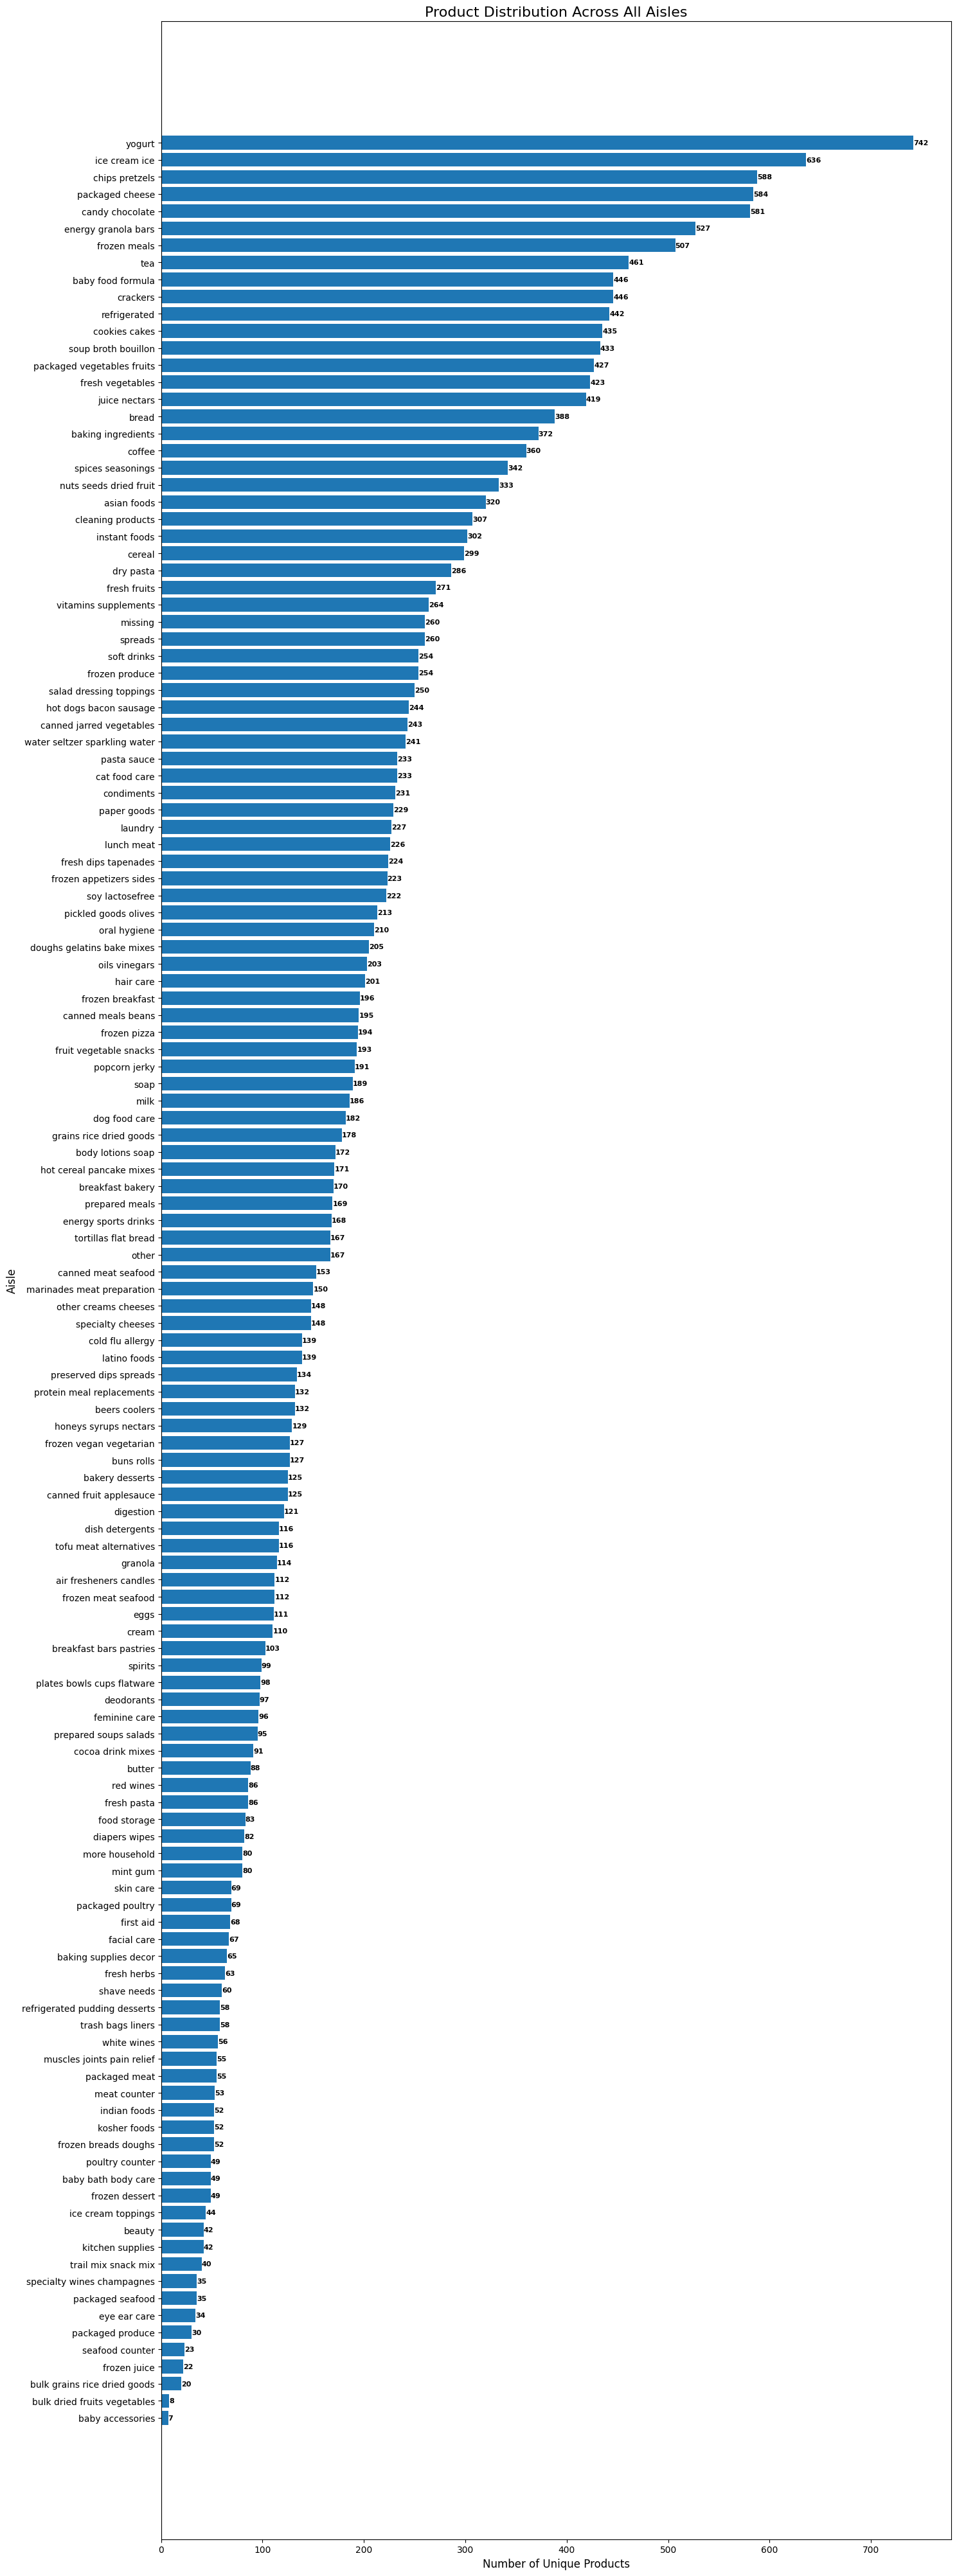

In [ ]:

import matplotlib.pyplot as plt

# Group and sort the data
aisle_product_counts = updated_retail.groupby('aisle')['product_id'].nunique().sort_values(ascending=True)

# Create the plot
plt.figure(figsize=(15, len(aisle_product_counts) * 0.3))  # Adjust height based on number of aisles
bars = plt.barh(aisle_product_counts.index, aisle_product_counts.values)

# Customize the plot
plt.title('Product Distribution Across All Aisles', fontsize=16)
plt.xlabel('Number of Unique Products', fontsize=12)
plt.ylabel('Aisle', fontsize=12)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)  # You can change this to an angle if needed (e.g., rotation=45)

# Add value labels to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}',
             ha='left', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

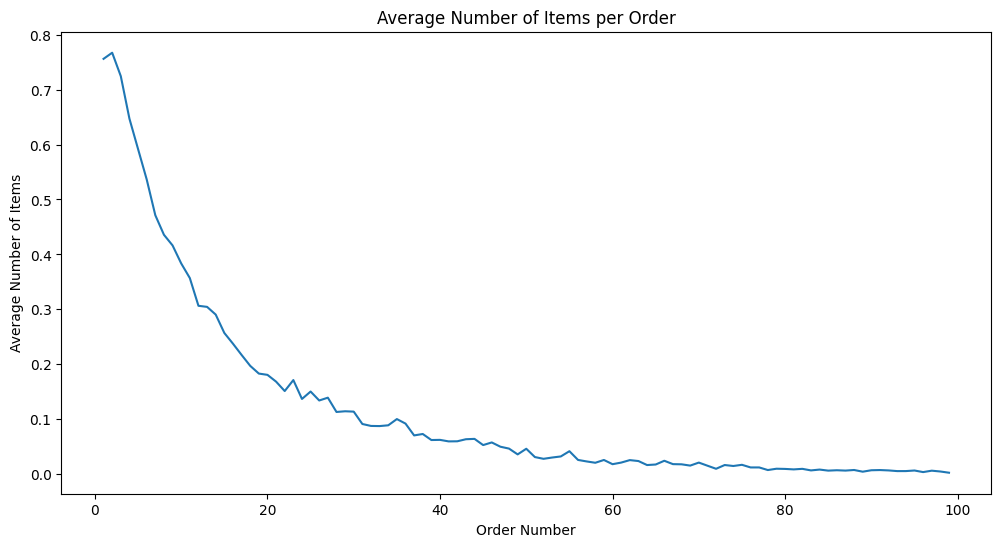

In [ ]:
# User behavior over time
user_order_counts = updated_retail.groupby(['user_id', 'order_number']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
user_order_counts.mean().plot()
plt.title('Average Number of Items per Order')
plt.xlabel('Order Number')
plt.ylabel('Average Number of Items')
plt.show()

**User-Item Interaction with Product--TOP 30 Users and by Product ID**

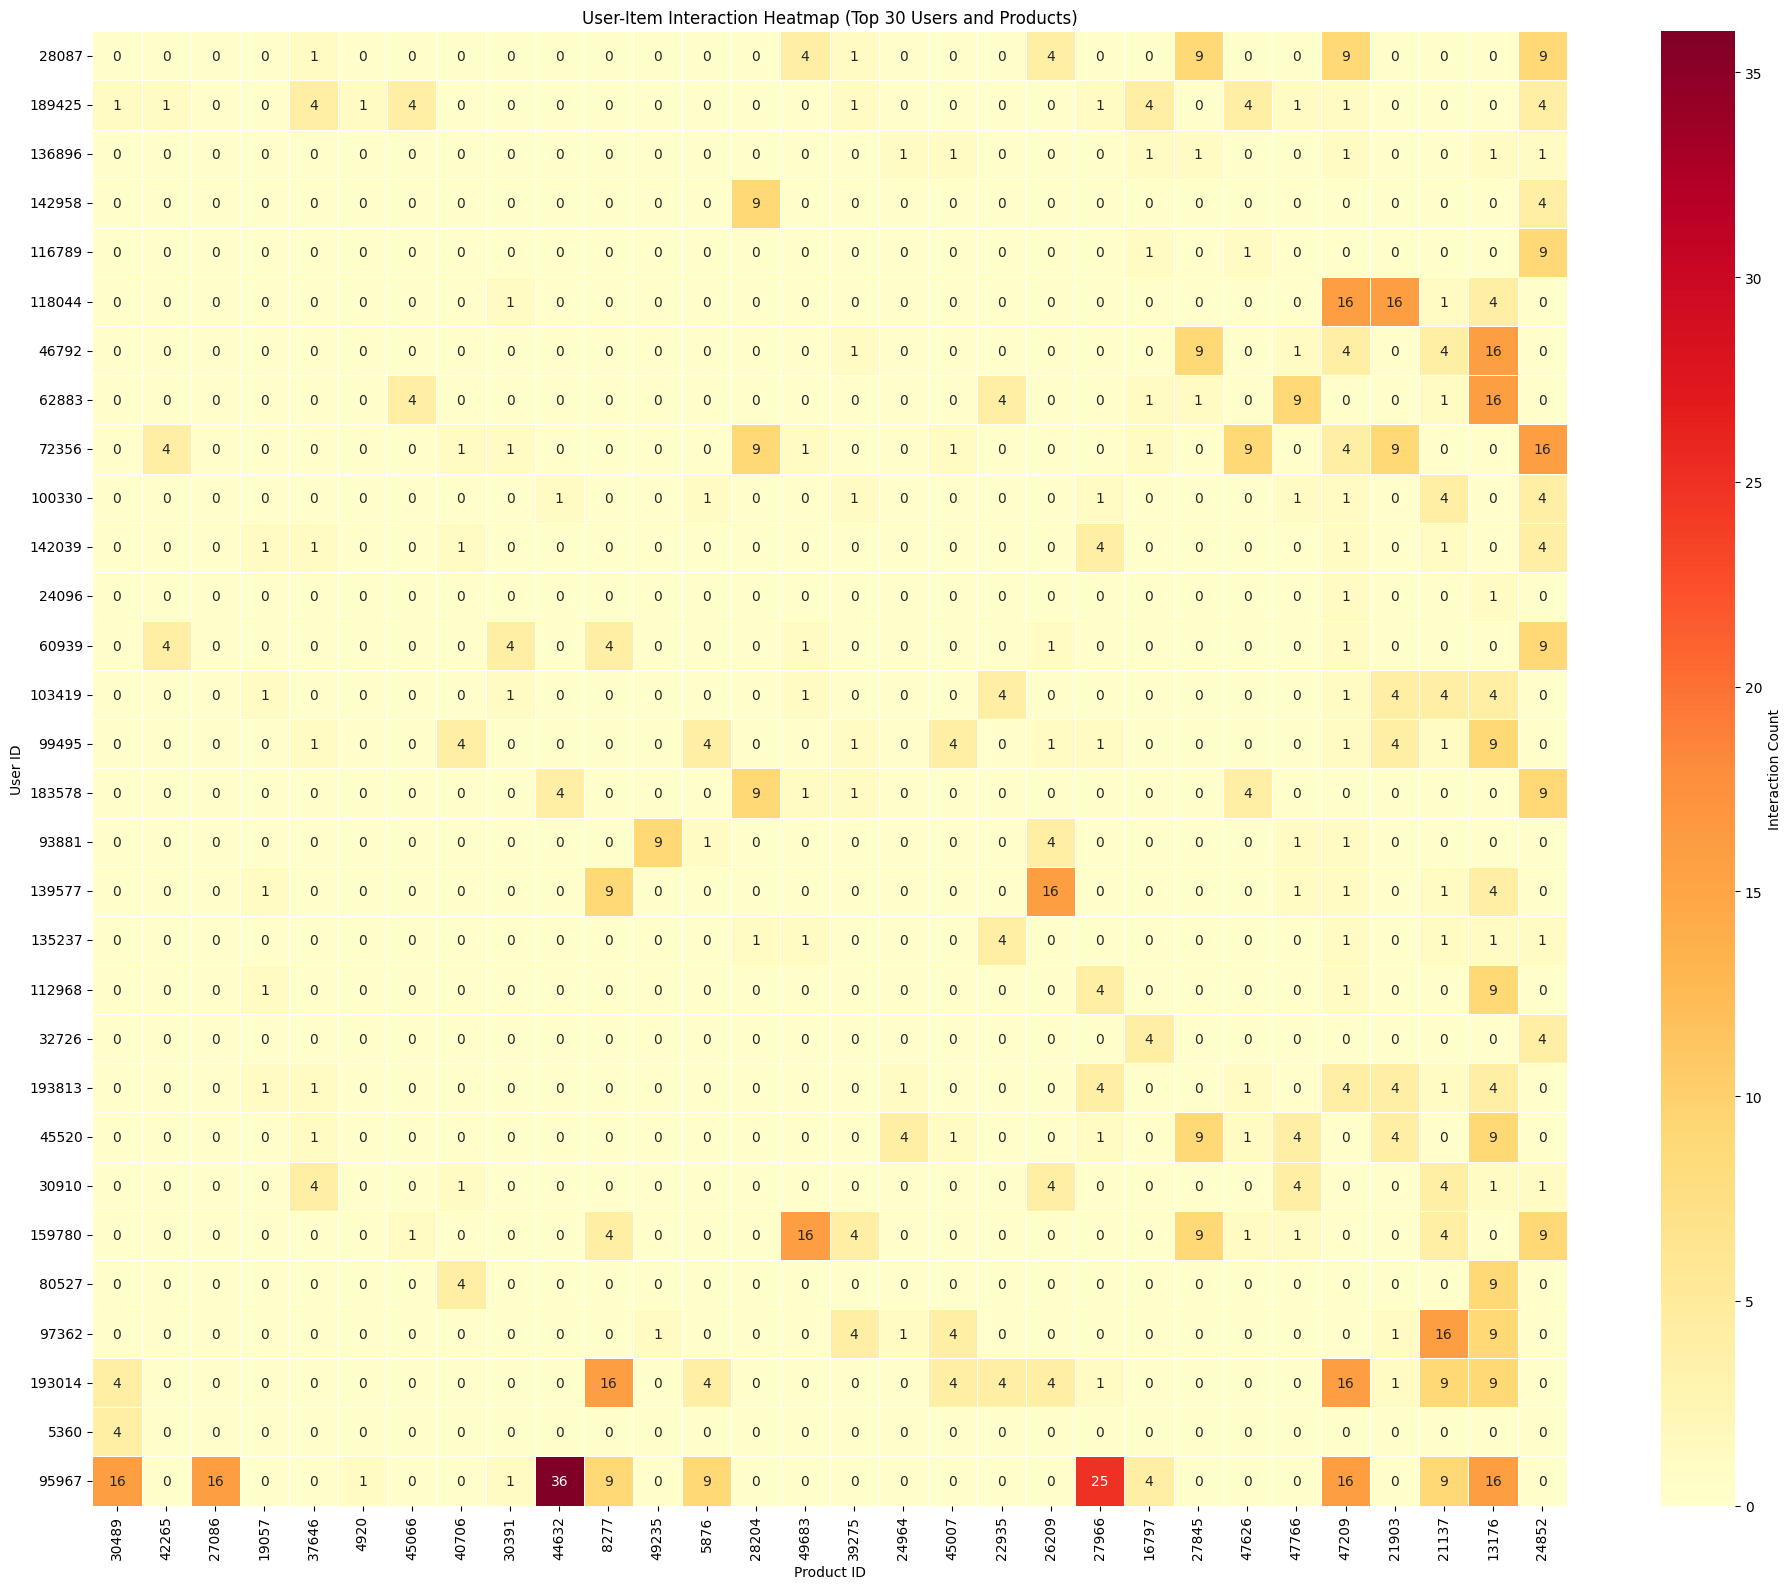

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create sparse matrix directly from your data
user_ids = updated_retail['user_id'].astype('category').cat.codes
product_ids = updated_retail['product_id'].astype('category').cat.codes
interaction_counts = updated_retail['interaction_count']

sparse_matrix = csr_matrix((interaction_counts, (user_ids, product_ids)))

# Get top N users and products
N = 30  # Reduced from 50 to 30 for better readability with annotations
top_users = np.argsort(sparse_matrix.sum(axis=1).A1)[-N:]
top_products = np.argsort(sparse_matrix.sum(axis=0).A1)[-N:]

# Create dense matrix for top users/products
small_matrix = sparse_matrix[top_users, :][:, top_products].todense()

# Get original user and product IDs
original_user_ids = updated_retail['user_id'].astype('category').cat.categories[top_users]
original_product_ids = updated_retail['product_id'].astype('category').cat.categories[top_products]

# Plot
plt.figure(figsize=(20, 16))  # Increased figure size for better readability
sns.heatmap(small_matrix,
            cmap='YlOrRd',
            annot=True,
            fmt='d',
            cbar_kws={'label': 'Interaction Count'},
            linewidths=0.5,
            square=True,
            xticklabels=original_product_ids,
            yticklabels=original_user_ids)

plt.title(f'User-Item Interaction Heatmap (Top {N} Users and Products)')
plt.xlabel('Product ID')
plt.ylabel('User ID')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split
def train_test_split_cf(df, test_size=0.2):
    train_data = df.copy()
    test_data = df.groupby('user_id').apply(lambda x: x.sample(frac=test_size)).reset_index(drop=True)
    train_data = train_data.drop(test_data.index)
    return train_data, test_data  # Changed test_df to test_data

# Split the data
train_df, test_df = train_test_split_cf(updated_retail, test_size=0.2)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (260725, 17)
Test shape: (64914, 17)


In [ ]:
# Save to CSV files
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

In [ ]:
#  Handle missing values in days_since_prior_order
train_df['days_since_prior_order'] = train_df['days_since_prior_order'].fillna(train_df['days_since_prior_order'].median())
test_df['days_since_prior_order'] = test_df['days_since_prior_order'].fillna(train_df['days_since_prior_order'].median())

# Save the updated DataFrames back to CSV
train_df.to_csv('train_data_cleaned.csv', index=False)
test_df.to_csv('test_data_cleaned.csv', index=False)

In [ ]:
print("\nMissing values in train set after handling:")
print(train_df.isnull().sum())
print("\nMissing values in test set after handling:")
print(test_df.isnull().sum())


Missing values in train set after handling:
user_id                   0
product_id                0
order_id                  0
add_to_cart_order         0
reordered                 0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
interaction_count         0
total_orders              0
product_order_rate        0
dtype: int64

Missing values in test set after handling:
user_id                   0
product_id                0
order_id                  0
add_to_cart_order         0
reordered                 0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
interaction_count         0
to

In [ ]:
from scipy.sparse import csr_matrix

def create_sparse_interaction_matrix(df):
    users = df['user_id'].astype('category').cat.codes
    items = df['product_id'].astype('category').cat.codes
    interactions = df['interaction_count']

    return csr_matrix((interactions, (users, items)))

train_matrix = create_sparse_interaction_matrix(train_df)
test_matrix = create_sparse_interaction_matrix(test_df)

print("Train matrix shape:", train_matrix.shape)
print("Test matrix shape:", test_matrix.shape)

Train matrix shape: (22162, 23684)
Test matrix shape: (25146, 13289)


# Exploratory Data Analysis on Training Set


**1. Box plot of order_number by user_id (for a sample of users n = 20)**

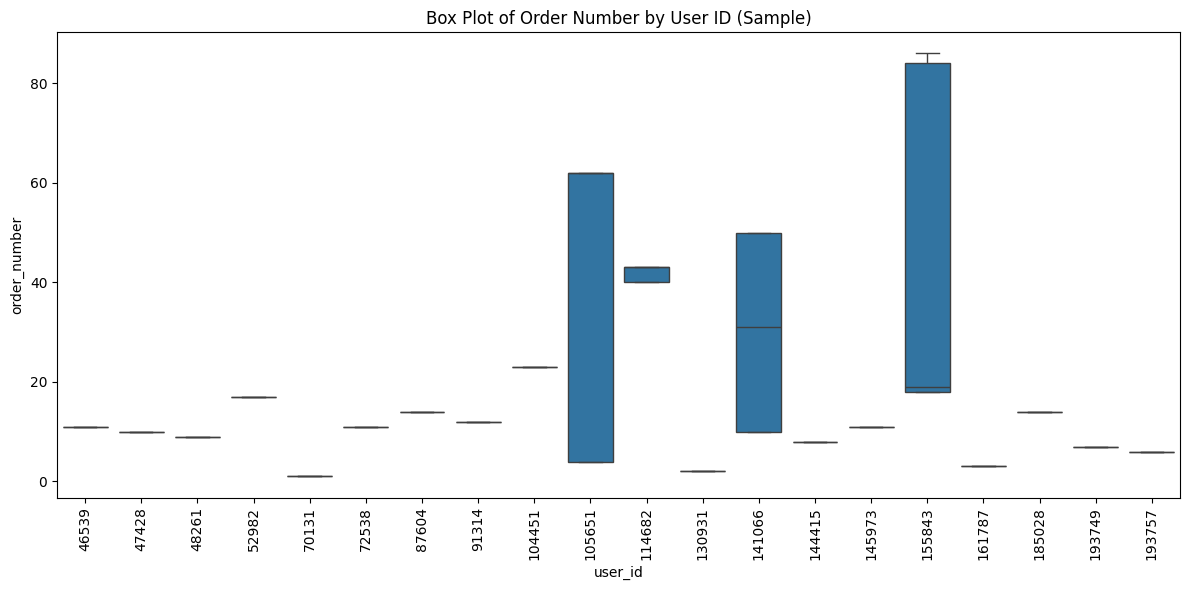

In [ ]:
# 1. Box plot of order_number by user_id (for a sample of users n = 20)
plt.figure(figsize=(12, 6))
sample_users = train_df['user_id'].sample(n=20)
sns.boxplot(x='user_id', y='order_number', data=train_df[train_df['user_id'].isin(sample_users)])
plt.title('Box Plot of Order Number by User ID (Sample)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**2. Histogram of unique products per user**

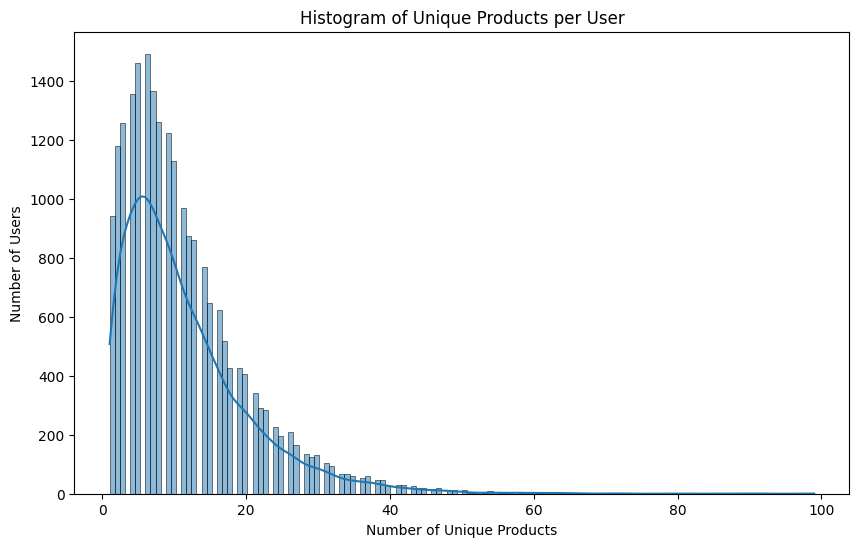

In [ ]:
# 2. Histogram of unique products per user
unique_products_per_user = train_df.groupby('user_id')['product_id'].nunique()
plt.figure(figsize=(10, 6))
sns.histplot(unique_products_per_user, kde=True)
plt.title('Histogram of Unique Products per User')
plt.xlabel('Number of Unique Products')
plt.ylabel('Number of Users')
plt.show()

**3. Histogram of reordered ratio per product**

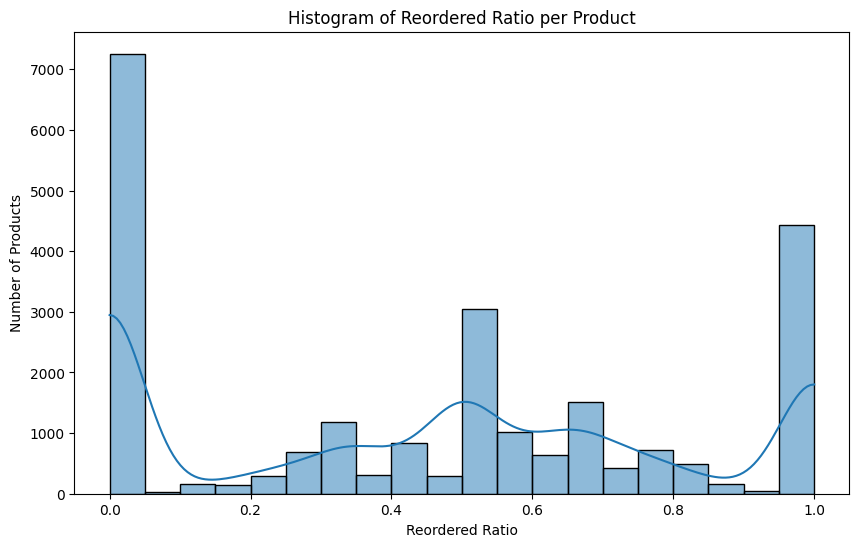

In [ ]:
# 3. Histogram of reordered ratio per product
reorder_ratio = train_df.groupby('product_id')['reordered'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(reorder_ratio, kde=True)
plt.title('Histogram of Reordered Ratio per Product')
plt.xlabel('Reordered Ratio')
plt.ylabel('Number of Products')
plt.show()

**4. Bar chart of top 20 most popular products**

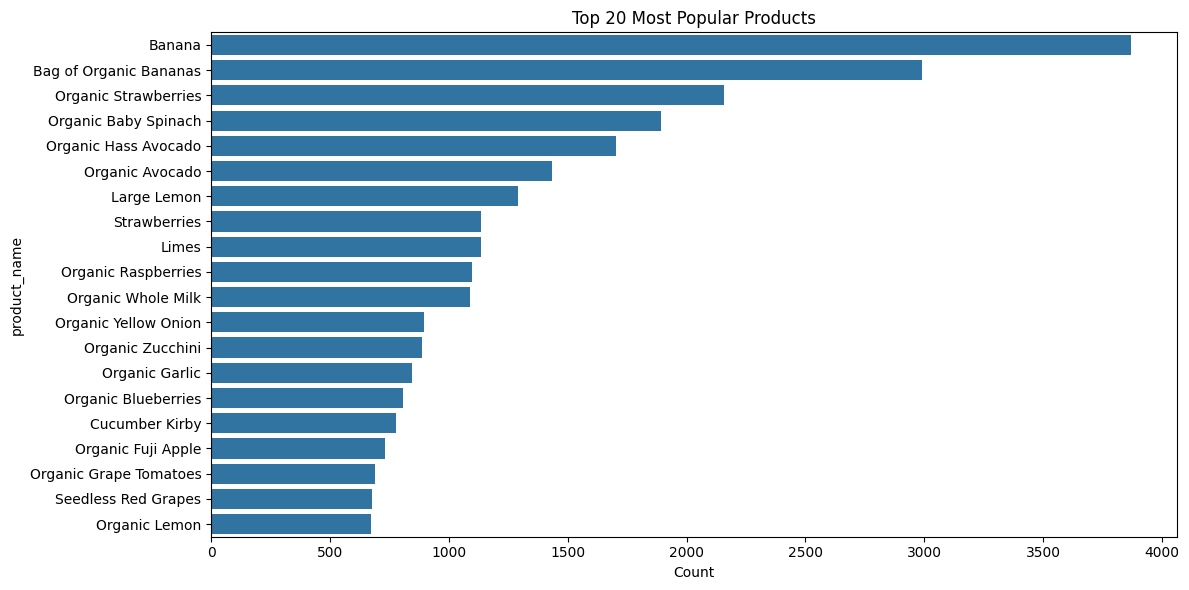

In [ ]:
# 4. Bar chart of top 20 most popular products
N = 20
top_products = train_df['product_name'].value_counts().nlargest(N)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title(f'Top {N} Most Popular Products')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

**5. Heatmap of order_dow vs order_hour_of_day**

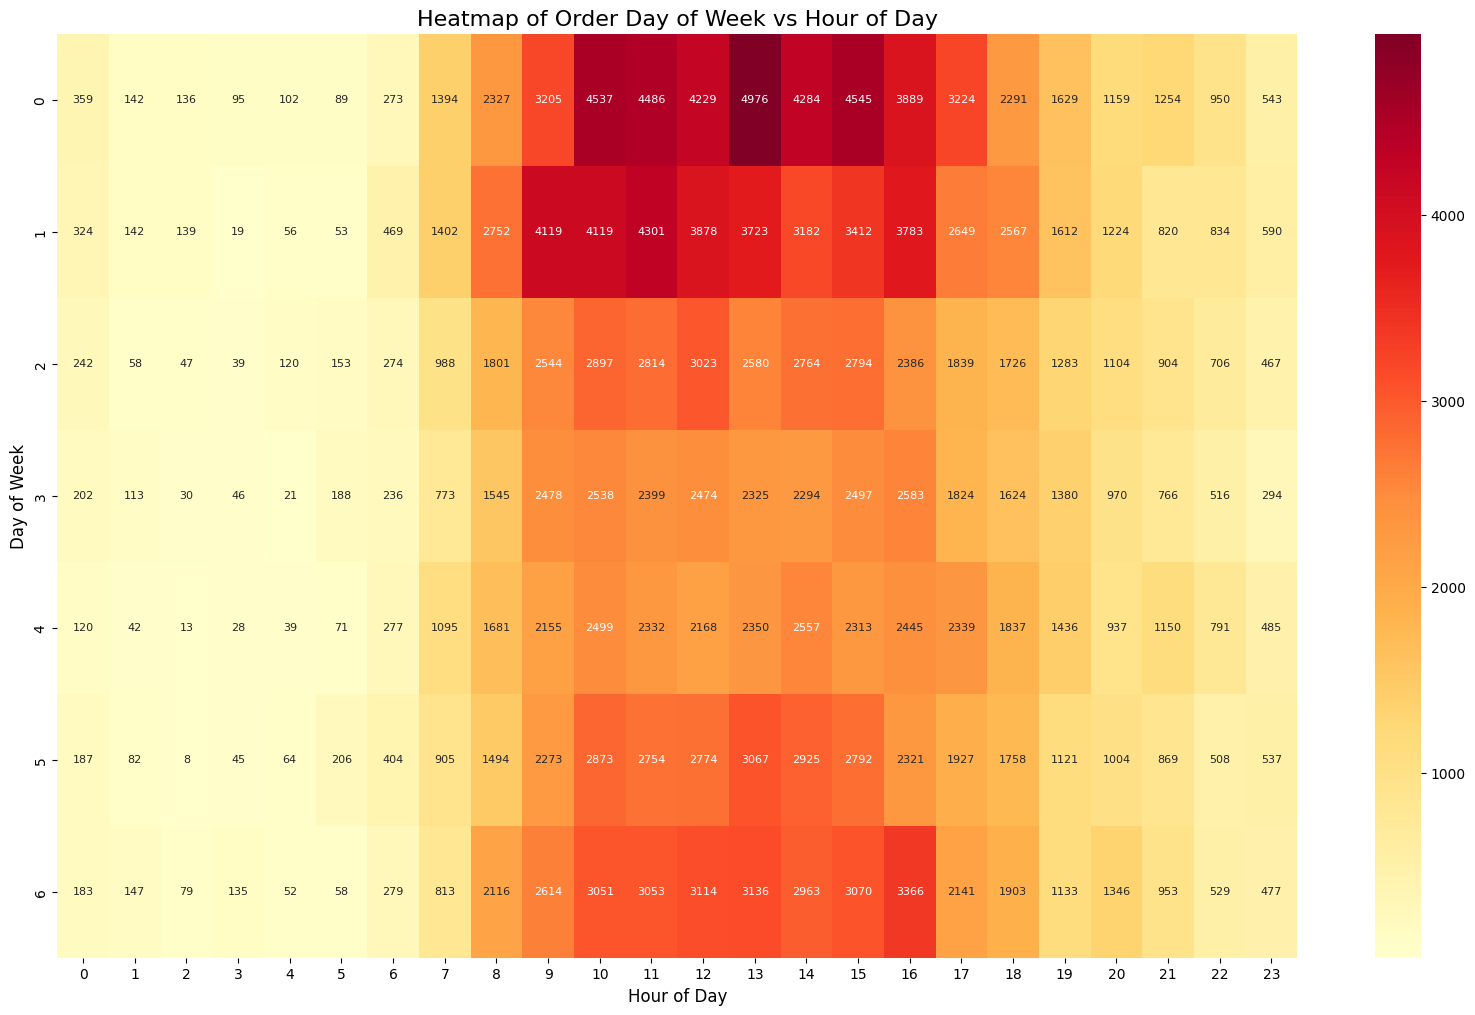

In [ ]:
# 5. Heatmap of order_dow vs order_hour_of_day
order_heatmap = pd.crosstab(train_df['order_dow'], train_df['order_hour_of_day'])
plt.figure(figsize=(20, 12))  # Increased figure size
sns.heatmap(order_heatmap, cmap='YlOrRd', annot=True, fmt='d', annot_kws={'size': 8})
plt.title('Heatmap of Order Day of Week vs Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.show()

**6. Heatmap for user-item interaction-- Top 20 users and Top 20 products by product ID**

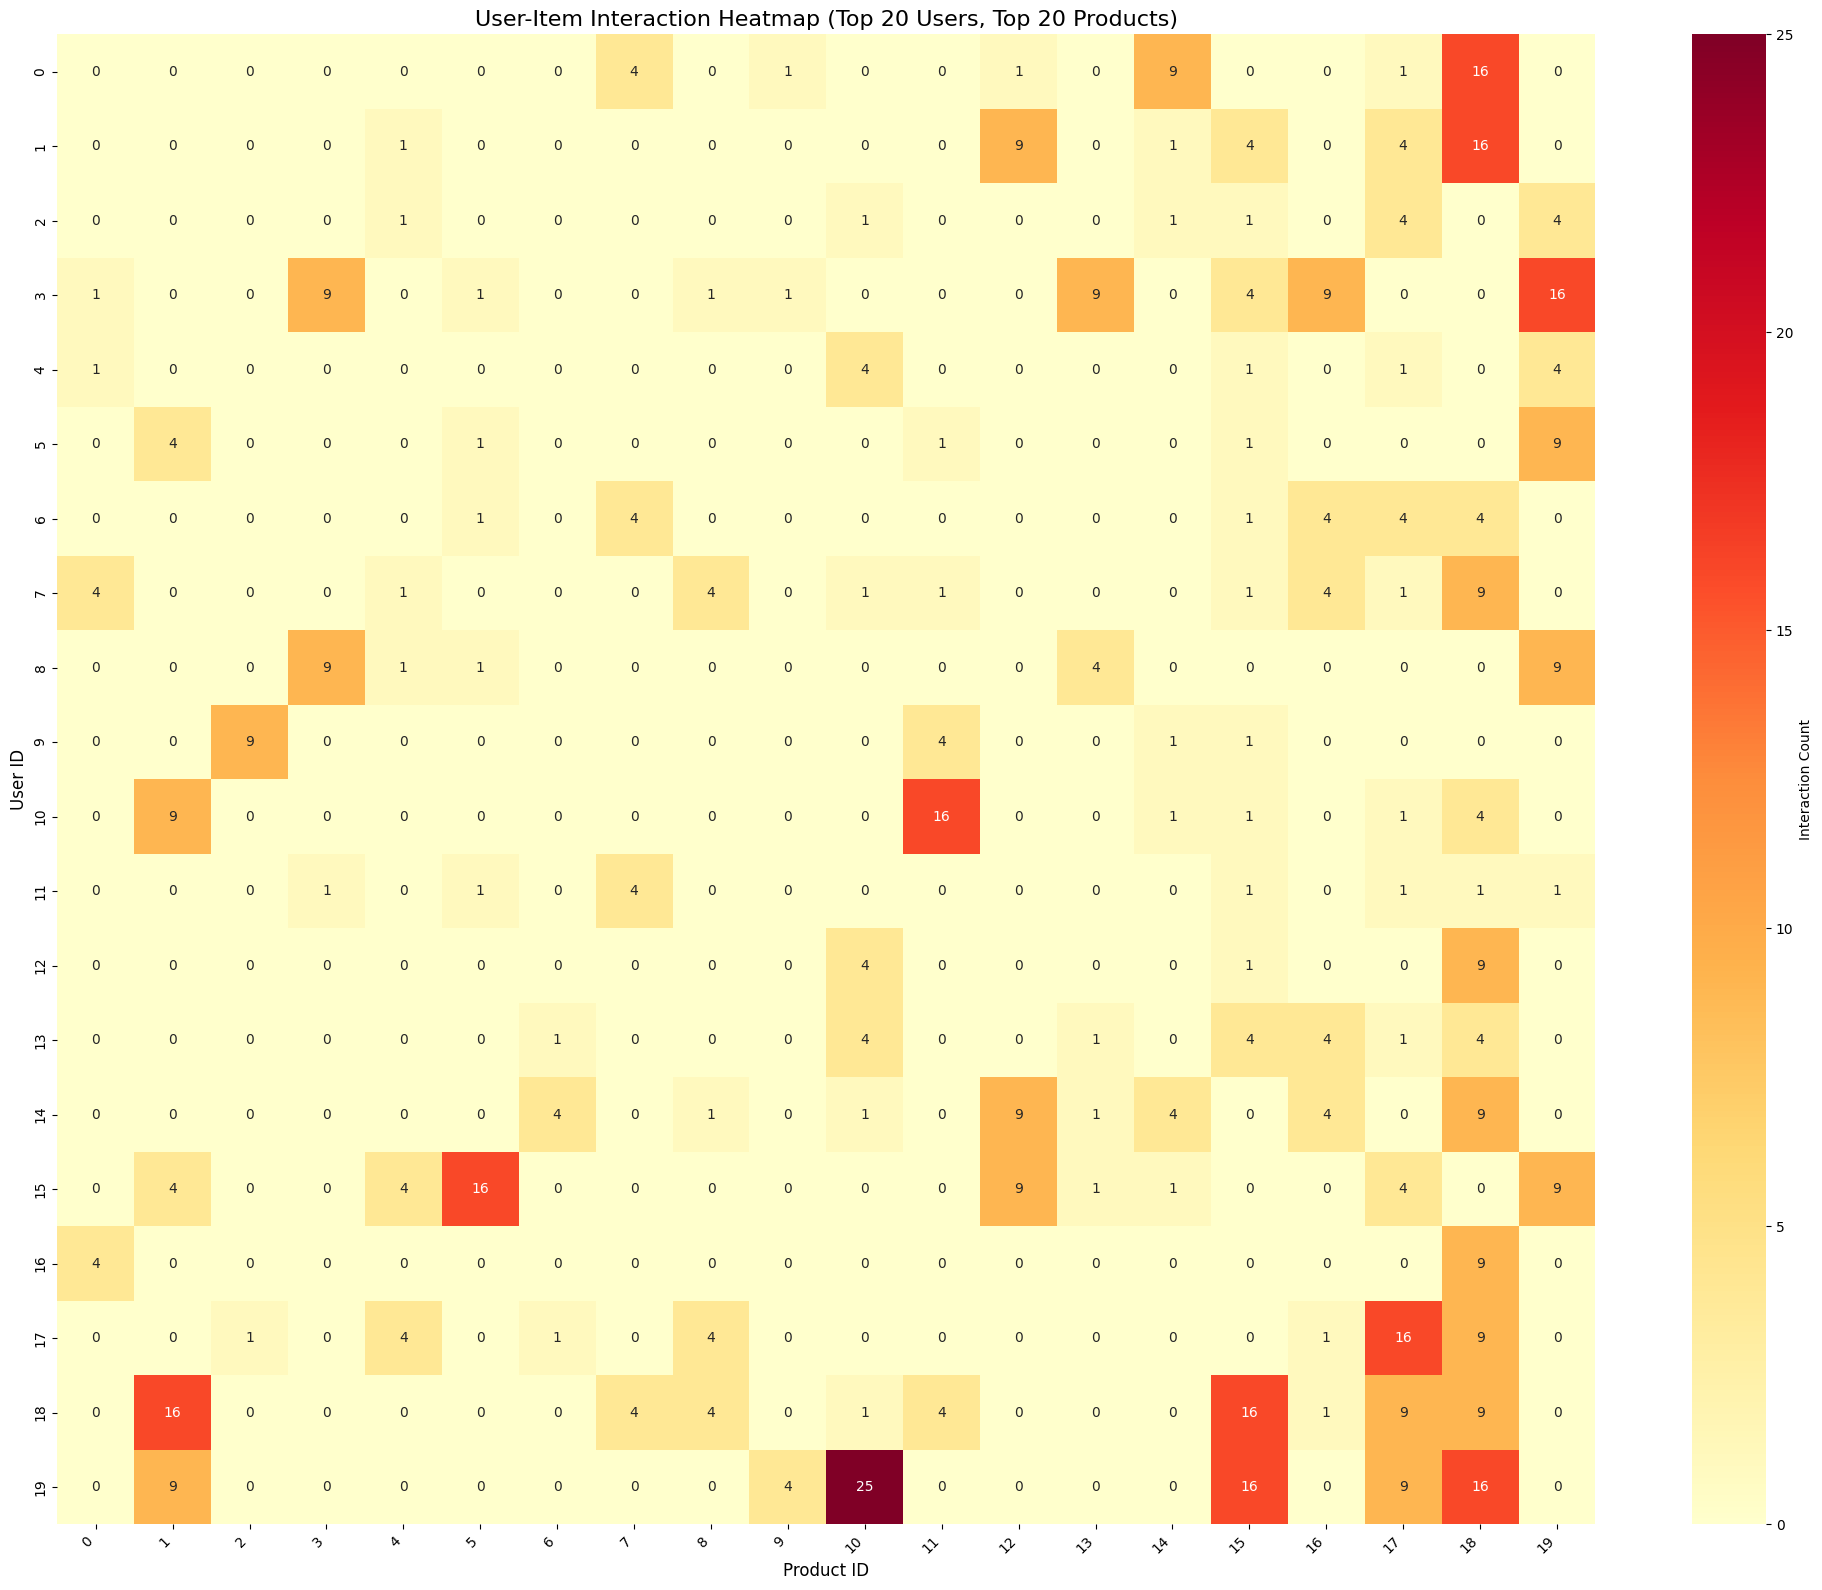

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_user_item_heatmap(matrix, n_users=20, n_items=20):
    # Convert to dense array for summing
    user_totals = np.array(matrix.sum(axis=1)).flatten()
    item_totals = np.array(matrix.sum(axis=0)).flatten()

    # Get indices of top users and items
    top_users = np.argsort(user_totals)[-n_users:]
    top_items = np.argsort(item_totals)[-n_items:]

    # Create sub-matrix
    sub_matrix = matrix[top_users, :][:, top_items].toarray()

    plt.figure(figsize=(20, 16))  # Increased figure size even more for better readability
    sns.heatmap(sub_matrix, cmap='YlOrRd', annot=True, fmt='d', cbar_kws={'label': 'Interaction Count'})
    plt.title(f'User-Item Interaction Heatmap (Top {n_users} Users, Top {n_items} Products)', fontsize=16)
    plt.xlabel('Product ID', fontsize=12)
    plt.ylabel('User ID', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()  # Adjust the layout to prevent cutting off labels
    plt.show()

# Assuming train_matrix is your sparse matrix
plot_user_item_heatmap(train_matrix)

**7. Bar Chart for user-item interaction-- Top 20 users and Top 20 products by product ID**

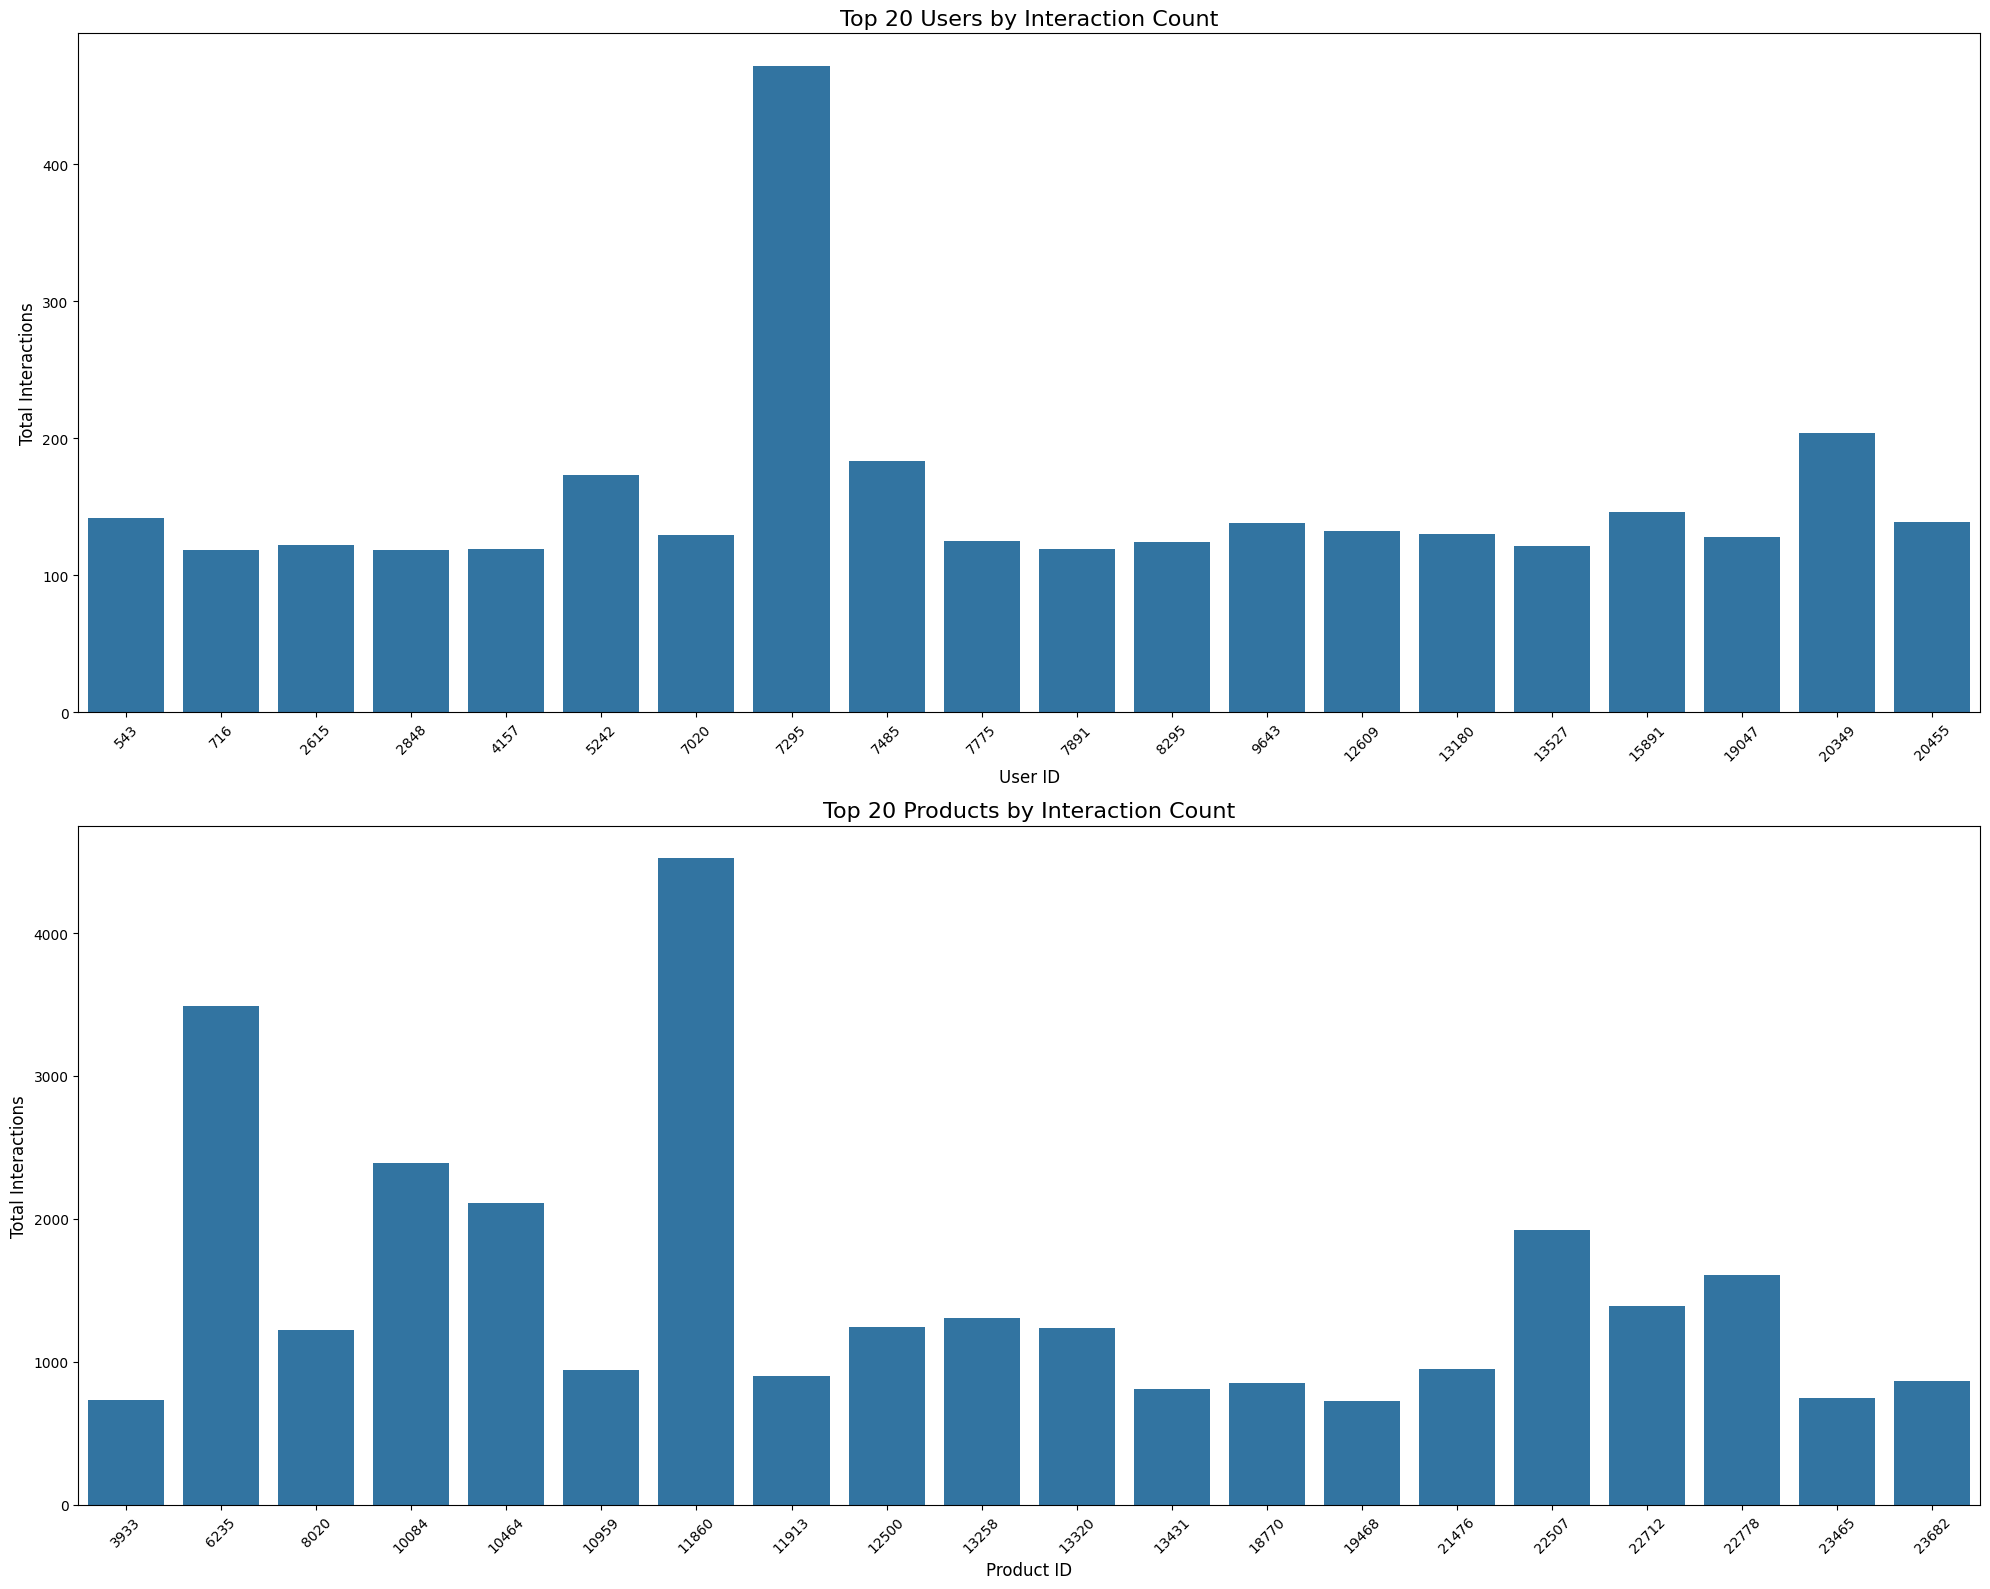

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_interactions_bar(matrix, n_users=20, n_items=20):
    # Convert to dense array for summing
    user_totals = np.array(matrix.sum(axis=1)).flatten()
    item_totals = np.array(matrix.sum(axis=0)).flatten()

    # Get indices of top users and items
    top_users = np.argsort(user_totals)[-n_users:]
    top_items = np.argsort(item_totals)[-n_items:]

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16))

    # Plot top users
    sns.barplot(x=top_users, y=user_totals[top_users], ax=ax1)
    ax1.set_title(f'Top {n_users} Users by Interaction Count', fontsize=16)
    ax1.set_xlabel('User ID', fontsize=12)
    ax1.set_ylabel('Total Interactions', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

    # Plot top items (products)
    sns.barplot(x=top_items, y=item_totals[top_items], ax=ax2)
    ax2.set_title(f'Top {n_items} Products by Interaction Count', fontsize=16)
    ax2.set_xlabel('Product ID', fontsize=12)
    ax2.set_ylabel('Total Interactions', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Assuming train_matrix is your sparse matrix
plot_top_interactions_bar(train_matrix)

**8. Box plot of add_to_cart_order by department**

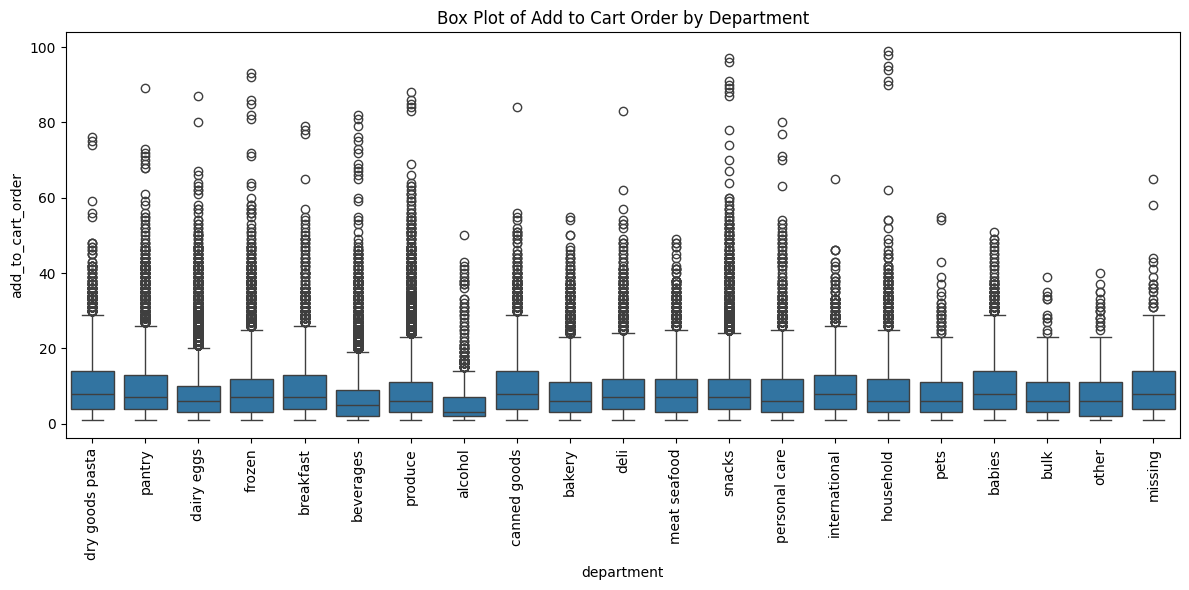

In [ ]:
# 8. Box plot of add_to_cart_order by department
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='add_to_cart_order', data=train_df)
plt.title('Box Plot of Add to Cart Order by Department')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**9. Scatter plot of reorder rate vs average days_since_prior_order for products**

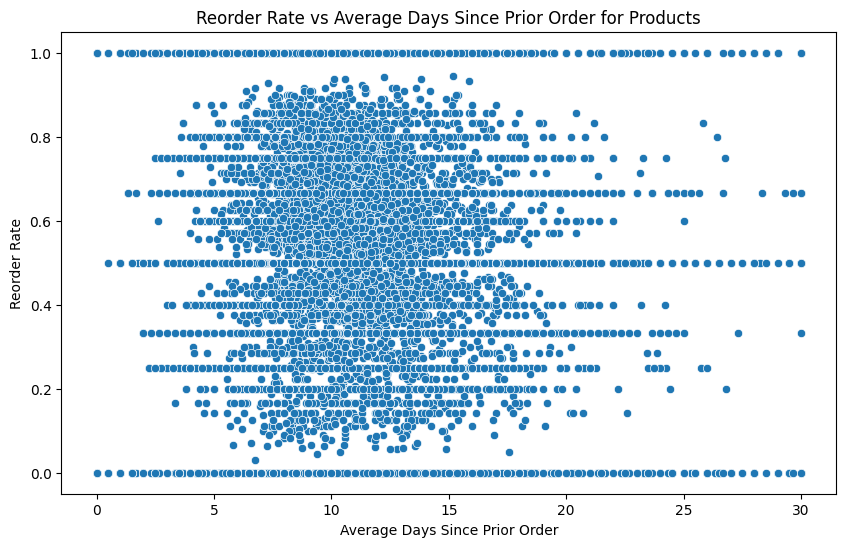

In [ ]:
# 9. Scatter plot of reorder rate vs average days_since_prior_order for products
product_stats = train_df.groupby('product_id').agg({
    'reordered': 'mean',
    'days_since_prior_order': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='days_since_prior_order', y='reordered', data=product_stats)
plt.title('Reorder Rate vs Average Days Since Prior Order for Products')
plt.xlabel('Average Days Since Prior Order')
plt.ylabel('Reorder Rate')
plt.show()

**10. Bar chart of average basket size by order_dow**

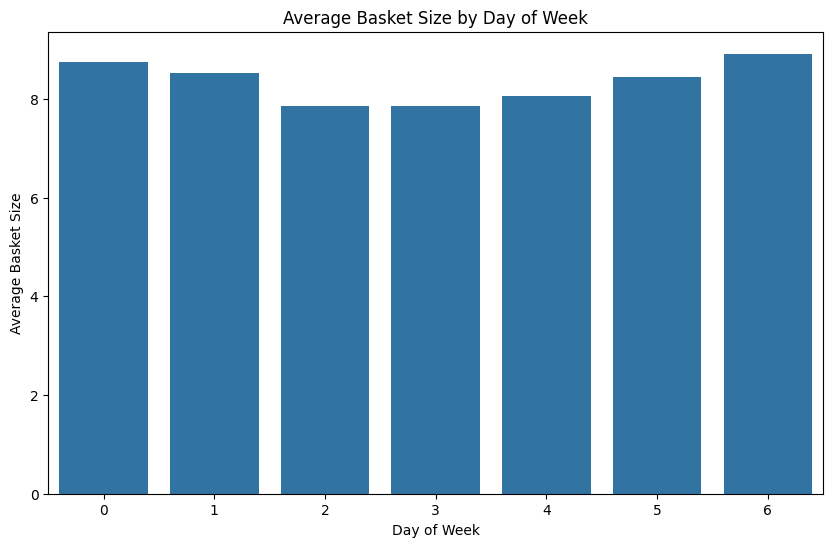

In [ ]:
# 10. Bar chart of average basket size by order_dow
avg_basket_size = train_df.groupby('order_dow')['add_to_cart_order'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_basket_size.index, y=avg_basket_size.values)
plt.title('Average Basket Size by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Basket Size')
plt.show()

**11. Box plot of days_since_prior_order by department**

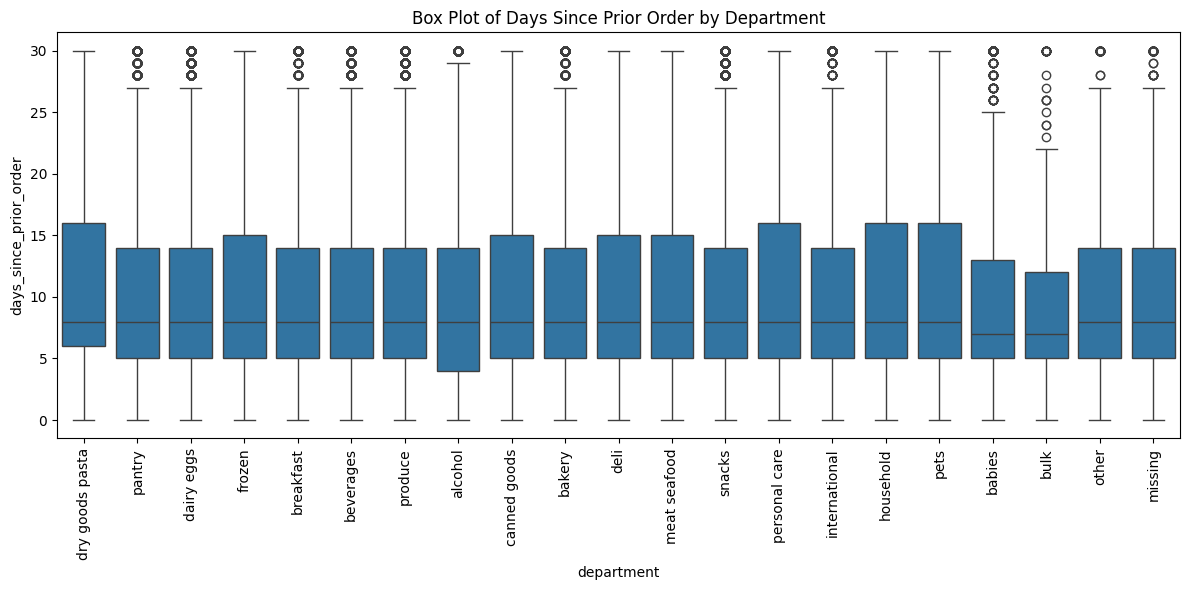

In [ ]:
# 11. Box plot of days_since_prior_order by department
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='days_since_prior_order', data=train_df)
plt.title('Box Plot of Days Since Prior Order by Department')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Identified the top 5 users who buy the most bananas using the items Interaction counts**

Top 5 Banana Buyers:
user_id
78562    4
44569    1
51910    1
53920    1
59250    1
Name: interaction_count, dtype: int64


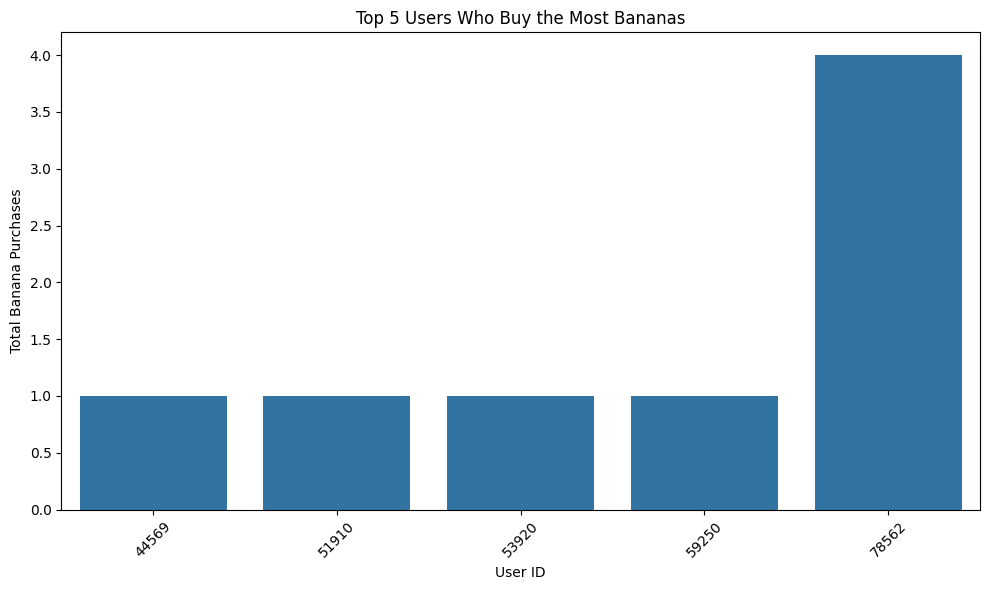

In [ ]:
# Identify the top 5 users who buy the most "Bananas"
banana_buyers = train_df[train_df['product_name'] == 'Bananas']
top_banana_buyers = banana_buyers.groupby('user_id')['interaction_count'].sum().nlargest(5)

print("Top 5 Banana Buyers:")
print(top_banana_buyers)

# Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x=top_banana_buyers.index, y=top_banana_buyers.values)
plt.title('Top 5 Users Who Buy the Most Bananas')
plt.xlabel('User ID')
plt.ylabel('Total Banana Purchases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Additional analysis: Banana purchase patterns for top buyers
for user_id in top_banana_buyers.index:
    user_data = train_df[(train_df['user_id'] == user_id) & (train_df['product_name'] == 'Bananas')]
    print(f"\nUser {user_id} Banana Purchase Patterns:")
    print(f"Total Purchases: {user_data['interaction_count'].sum()}")
    print(f"Average Order Position: {user_data['add_to_cart_order'].mean():.2f}")
    print(f"Reorder Rate: {user_data['reordered'].mean():.2%}")
    print(f"Average Days Between Orders: {user_data['days_since_prior_order'].mean():.2f}")


User 78562 Banana Purchase Patterns:
Total Purchases: 4
Average Order Position: 6.50
Reorder Rate: 100.00%
Average Days Between Orders: 6.00

User 44569 Banana Purchase Patterns:
Total Purchases: 1
Average Order Position: 10.00
Reorder Rate: 0.00%
Average Days Between Orders: 5.00

User 51910 Banana Purchase Patterns:
Total Purchases: 1
Average Order Position: 8.00
Reorder Rate: 100.00%
Average Days Between Orders: 4.00

User 53920 Banana Purchase Patterns:
Total Purchases: 1
Average Order Position: 9.00
Reorder Rate: 100.00%
Average Days Between Orders: 9.00

User 59250 Banana Purchase Patterns:
Total Purchases: 1
Average Order Position: 1.00
Reorder Rate: 100.00%
Average Days Between Orders: 7.00


# Summary


1. **Dataset to Use is:**


*   test_data_cleaned.csv
*   train_data_cleaned.csv


2. Added Three Columns


a) **interaction_count:**This column counts how many times each user-product
combination appears in the dataset. It helps with **identifying frequently purchased products for each user**.

b) **total_orders:** This column counts the unique orders for each user. It gives us an idea of **how active each user is on the platform**.

c) **product_order_rate:**  This is calculated as interaction_count / total_orders. **It represents the proportion of a user's orders that include a specific product, indicating how frequently a user buys a particular product relative to their overall purchasing behavior**.


3. **Checked For Missing Value and handled it.**


4. **Visualized both the Entire Dataset, As well as the Training dataset.**


5. I have identified the top 5 users who buy the most bananas by using there **User ID** and **Interaction-count**.


6. **NEXT STEPS**

We now need to determine the top product recommended for these users based on their purchasing behavior




#**Collaborative filtering recommender system using Cosine similarity**#

In [3]:
import pandas as pd
# Loading data
#aisles = pd.read_csv('aisles.csv')
#departments = pd.read_csv('departments.csv')
order_products = pd.read_csv('order_products.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')



In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
#print(aisles.shape)
#print(departments.shape)
print(order_products.shape)
print(orders.shape)
print(products.shape)

(32434489, 4)
(3421083, 7)
(49688, 4)


In [4]:
# Merging data
merged_data = pd.merge(order_products, orders, on="order_id")

merged_data.shape


(32434489, 10)

In [ ]:
print(merged_data.isna().sum())

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64


In [ ]:
#Sampling
sampled_data = merged_data.sample(n=1_000_000, random_state=42)

print(sampled_data.isna().sum())



order_id                      0
product_id                    0
add_to_cart_order             0
reordered                     0
user_id                       0
eval_set                      0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    64081
dtype: int64


In [ ]:
#User-product interaction matrix (counting each user's purchases of each product)
user_product_interactions = pd.pivot_table(sampled_data, index='user_id', columns='product_id', aggfunc='size', fill_value=0)


user_product_interactions.shape




(169291, 34995)

In [ ]:
user_product_interactions.head(20)


product_id,1,2,3,4,6,8,9,10,11,12,...,49677,49678,49679,49680,49681,49682,49683,49685,49686,49688
user_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Item - Item similarity matrix

from sklearn.metrics.pairwise import cosine_similarity

# item-item similarity matrix using cosine similarity
item_similarity = cosine_similarity(user_product_interactions.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_product_interactions.columns, columns=user_product_interactions.columns)


item_similarity_df.head()

product_id,1,2,3,4,6,8,9,10,11,12,...,49677,49678,49679,49680,49681,49682,49683,49685,49686,49688
product_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#**Recommendations based on item similarity**

In [ ]:
def get_top_n_recommendations(user_id, user_product_interactions, item_similarity_df, products_df, n=5):

    user_interactions = user_product_interactions.loc[user_id]
    user_interacted_products = user_interactions[user_interactions > 0].index.tolist()


    scores = {}
    for product in user_interacted_products:
        similar_products = item_similarity_df[product].sort_values(ascending=False)


        for similar_product, similarity_score in similar_products.items():
            if similar_product not in user_interacted_products:
                scores[similar_product] = scores.get(similar_product, 0) + similarity_score


    recommended_product_ids = sorted(scores, key=scores.get, reverse=True)[:n]


    recommended_product_names = products_df[products_df['product_id'].isin(recommended_product_ids)]['product_name'].tolist()

    return recommended_product_names

def recommend_for_user(user_id, user_product_interactions, item_similarity_df, products_df, n=5):
    recommendations = get_top_n_recommendations(user_id, user_product_interactions, item_similarity_df, products_df, n)
    print(f"Recommended products for User {user_id}: {', '.join(recommendations)}")




Enter User ID to get recommendations: 2
Recommended products for User 2: Total 2% with Raspberry Pomegranate Lowfat Greek Strained Yogurt, Bag of Organic Bananas, Total 0% Peach Yogurt, Fat Free Strawberry Yogurt, Organic Strawberries


#**Top 5 Recommendations**

In [ ]:

valid_user_ids = orders['user_id'].unique()


def recommend_for_user(user_id, user_product_interactions, item_similarity_df, products_df, n=5):
    recommendations = get_top_n_recommendations(user_id, user_product_interactions, item_similarity_df, products_df, n)
    print(f"Recommended products for User {user_id}: {', '.join(recommendations)}")


while True:
    try:
        user_id_input = int(input("Enter User ID to get recommendations: "))


        if user_id_input in valid_user_ids:
            recommend_for_user(user_id_input, user_product_interactions, item_similarity_df, products, n=5)
            break
        else:
            print("User ID not found in order_products. Please enter a valid User ID.")
    except ValueError:
        print("Invalid input. Please enter a numerical User ID.")


Enter User ID to get recommendations: 10000000
User ID not found in order_products. Please enter a valid User ID.
Enter User ID to get recommendations: 100000
Recommended products for User 100000: Bud Light Beer Cans, 4.5\" Street Taco Flour Tortilla, White Paper #2 Size Cone Coffee Filters, Great White Beer, Organics White Corn Tortilla Chips


**Evaluation**

In [38]:



def map_names_to_ids(predicted_recommendations, products_df):

    product_name_to_id = dict(zip(products_df['product_name'], products_df['product_id']))

    predicted_recommendations_ids = [
        product_name_to_id.get(name, None) for name in predicted_recommendations
    ]

    return [prod_id for prod_id in predicted_recommendations_ids if prod_id is not None]


random_users = np.random.choice(user_product_interactions.index, size=1000, replace=False)


def evaluate_recommender_model(user_ids, user_product_interactions, item_similarity_df, products_df, k=5):

    map5_scores = []
    precision_at_5_scores = []

    for user_id in user_ids:

        user_interactions = user_product_interactions.loc[user_id]
        actual_purchases = user_interactions[user_interactions > 0].index.tolist()


        if len(actual_purchases) == 0:
            continue


        predicted_recommendations = get_top_n_recommendations(user_id, user_product_interactions, item_similarity_df, products_df, n=k)

        predicted_recommendations_ids = map_names_to_ids(predicted_recommendations, products_df)

        if len(predicted_recommendations_ids) == 0:
            continue

        map5_scores.append(apk(actual_purchases, predicted_recommendations_ids, k=k))
        precision_at_5_scores.append(precision_at_k(actual_purchases, predicted_recommendations_ids, k=k))


    if map5_scores and precision_at_5_scores:
        mean_map5_score = np.mean(map5_scores)
        mean_precision_at_5 = np.mean(precision_at_5_scores)
    else:
        mean_map5_score, mean_precision_at_5 = 0.0, 0.0

    return mean_map5_score, mean_precision_at_5


mean_map5, mean_precision5 = evaluate_recommender_model(random_users, user_product_interactions, item_similarity_df, products, k=5)

print(f"Mean MAP@5 for 1000 users: {mean_map5}")
print(f"Mean Precision@5 for 1000 users: {mean_precision5}")


Mean MAP@5 for 1000 users: 0.0
Mean Precision@5 for 1000 users: 0.0


From above, it can be said that recommended items are not at all relevant

In [39]:

def map_names_to_ids(predicted_recommendations, products_df):

    product_name_to_id = dict(zip(products_df['product_name'], products_df['product_id']))


    predicted_recommendations_ids = [
        product_name_to_id.get(name, None) for name in predicted_recommendations
    ]

    return [prod_id for prod_id in predicted_recommendations_ids if prod_id is not None]


random_users = np.random.choice(user_product_interactions.index, size=10, replace=False)


def display_predictions_vs_actual(user_ids, user_product_interactions, item_similarity_df, products_df, k=5):
    for user_id in user_ids:

        user_interactions = user_product_interactions.loc[user_id]
        actual_purchases = user_interactions[user_interactions > 0].index.tolist()


        predicted_recommendations = get_top_n_recommendations(user_id, user_product_interactions, item_similarity_df, products_df, n=k)


        predicted_recommendations_ids = map_names_to_ids(predicted_recommendations, products_df)


        print(f"User {user_id}")
        print(f"Actual Purchases: {actual_purchases}")
        print(f"Predicted Recommendations: {predicted_recommendations}")
        print(f"Predicted Recommendations (IDs): {predicted_recommendations_ids}")
        print("-" * 50)


display_predictions_vs_actual(random_users, user_product_interactions, item_similarity_df, products, k=5)


User 27424
Actual Purchases: [24838, 31477]
Predicted Recommendations: ['Cat Treats Hair Ball Control Chicken', 'HE Liquid Laundry Detergent with Downy, April Fresh scent', 'Gold Digital Pregnancy Test', 'Full Head Medium Toothbrush', 'Chocolate Chip Cookie Dough Frozen Greek Yogurt Bars']
Predicted Recommendations (IDs): [779, 30524, 37314, 39648, 46475]
--------------------------------------------------
User 52011
Actual Purchases: [4781, 5322, 8929, 12029, 12419, 16759, 21616, 47119]
Predicted Recommendations: ['Tradtional Hot Chocolate Mix', 'Organic Strawberries', 'Long Reach Matches', 'Organic Hass Avocado', 'Kids Super Apple Fruit & Veggie Shredz']
Predicted Recommendations (IDs): [1595, 21137, 44456, 47209, 48387]
--------------------------------------------------
User 28271
Actual Purchases: [23785]
Predicted Recommendations: ['Baby Fresh Pampers Baby Wipes Baby Fresh 1X 64 count  Baby Wipes', 'Apple Juice Fruit', 'Baby Shampoo With Lavender', 'Yellow Rice & Chicken with Veget

**Emperical Tuning 1**

In [48]:

from sklearn.metrics import pairwise_distances


def get_top_n_recommendations(user_id, user_product_interactions, item_similarity_df, products_df, n=5):

    user_interacted_products = user_product_interactions.loc[user_id]
    user_interacted_products = user_interacted_products[user_interacted_products > 0].index.tolist()

    scores = {}


    for product in user_interacted_products:
        similar_products = item_similarity_df[product].sort_values(ascending=False)

        for similar_product, score in similar_products.items():
            if similar_product not in user_interacted_products:
                if similar_product not in scores:
                    scores[similar_product] = score
                else:
                    scores[similar_product] += score


    recommended_products = sorted(scores, key=scores.get, reverse=True)[:n]
    return recommended_products


def calculate_item_similarity(user_product_interactions, metric='cosine'):
    similarity_matrix = pairwise_distances(user_product_interactions.T, metric=metric)


    similarity_df = pd.DataFrame(similarity_matrix, index=user_product_interactions.columns, columns=user_product_interactions.columns)

    return similarity_df


def empirical_tuning_round_1(user_product_interactions, item_similarity_df, products_df, k_values, similarity_measures, random_users, sample_size=100):
    best_map5 = 0
    best_precision5 = 0
    best_k = None
    best_similarity_measure = None


    sampled_users = np.random.choice(user_product_interactions.index, size=sample_size, replace=False)
    sampled_products = np.random.choice(user_product_interactions.columns, size=sample_size, replace=False)


    user_product_interactions_sampled = user_product_interactions.loc[sampled_users, sampled_products]


    for k in k_values:
        for similarity_measure in similarity_measures:
            print(f"Evaluating with k={k}, similarity_measure={similarity_measure}")


            if similarity_measure == 'cosine':
                item_similarity_df = calculate_item_similarity(user_product_interactions_sampled, metric='cosine')
            elif similarity_measure == 'pearson':
                item_similarity_df = calculate_item_similarity(user_product_interactions_sampled, metric='correlation')
            else:
                raise ValueError("Unsupported similarity measure")


            mean_map5, mean_precision5 = evaluate_recommender_model(sampled_users, user_product_interactions_sampled, item_similarity_df, products_df, k=k)

            print(f"MAP@5: {mean_map5}, Precision@5: {mean_precision5}")


            if mean_map5 > best_map5 and mean_precision5 > best_precision5:
                best_map5 = mean_map5
                best_precision5 = mean_precision5
                best_k = k
                best_similarity_measure = similarity_measure

    print(f"Best configuration: k={best_k}, similarity_measure={best_similarity_measure}")
    return best_k, best_similarity_measure, best_map5, best_precision5

k_values = [5, 10, 15]
similarity_measures = ['cosine', 'pearson']

random_users = np.random.choice(user_product_interactions.index, size=1000, replace=False)


best_k, best_similarity_measure, best_map5, best_precision5 = empirical_tuning_round_1(
    user_product_interactions, item_similarity_df, products, k_values, similarity_measures, random_users, sample_size=200
)

print(f"Best MAP@5 after round 1: {best_map5}")
print(f"Best Precision@5 after round 1: {best_precision5}")


Evaluating with k=5, similarity_measure=cosine
MAP@5: 0.0, Precision@5: 0.0
Evaluating with k=5, similarity_measure=pearson
MAP@5: 0.0, Precision@5: 0.0
Evaluating with k=10, similarity_measure=cosine
MAP@5: 0.0, Precision@5: 0.0
Evaluating with k=10, similarity_measure=pearson
MAP@5: 0.0, Precision@5: 0.0
Evaluating with k=15, similarity_measure=cosine
MAP@5: 0.0, Precision@5: 0.0
Evaluating with k=15, similarity_measure=pearson
MAP@5: 0.0, Precision@5: 0.0
Best configuration: k=None, similarity_measure=None
Best MAP@5 after round 1: 0
Best Precision@5 after round 1: 0


#**USER Based Collobarative filtering recommendation system**

In [5]:
sampled_data = merged_data.sample(n=10000, random_state=42)

print(sampled_data.isna().sum())


order_id                    0
product_id                  0
add_to_cart_order           0
reordered                   0
user_id                     0
eval_set                    0
order_number                0
order_dow                   0
order_hour_of_day           0
days_since_prior_order    641
dtype: int64


In [6]:
# user-item interaction matrix
user_item_matrix = sampled_data.groupby(['user_id', 'product_id']).size().unstack(fill_value=0)

user_item_matrix.head()


product_id,9,10,23,25,34,37,45,49,79,93,...,49605,49609,49610,49614,49621,49638,49644,49667,49678,49683
user_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)

# Convert similarity matrix to a DataFrame for easier readability
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Display the similarity matrix for the first 5 users
user_similarity_df.head()


user_id,2,9,38,58,77,117,140,150,154,164,...,205897,205943,205953,206017,206041,206046,206083,206102,206157,206185
user_id,,,,,,,,,,,,,,,,,,,,,
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#**Recommendations**

In [22]:
def get_user_based_recommendations(user_similarity_df, user_item_matrix, products_df, top_n=5):

    user_id = int(input("Enter user ID: "))


    if user_id not in user_item_matrix.index:
        print(f"User ID {user_id} not found in the user-item matrix.")
        return None


    user_similarities = user_similarity_df[user_id]

    similar_users = user_similarities.sort_values(ascending=False).iloc[1:top_n+1].index

    similar_user_items = user_item_matrix.loc[similar_users]


    weighted_scores = similar_user_items.T.dot(user_similarities[similar_users]) / user_similarities[similar_users].sum()


    recommended_products = weighted_scores.sort_values(ascending=False)


    top_n_product_ids = recommended_products.head(top_n).index


    recommended_product_names = products_df.set_index('product_id').loc[top_n_product_ids, 'product_name']

    return recommended_product_names


recommended_products = get_user_based_recommendations(user_similarity_df=user_similarity_df,
                                                     user_item_matrix=user_item_matrix,
                                                     products_df=products,
                                                     top_n=5)

if recommended_products is not None:
    print("Top recommended products:")
    print(recommended_products)


Enter user ID: 741
Top recommended products:
product_id
40604                 Feta Cheese Crumbles
9        Light Strawberry Blueberry Yogurt
33665           California Red Velvet Wine
33647       Blue Chips Corn Tortilla Chips
33636     Organic Shells And White Cheddar
Name: product_name, dtype: object


#**Evaluation**

In [27]:

def get_user_based_recommendations(user_id, user_similarity_df, user_item_matrix, products_df, top_n=5):

    if user_id not in user_item_matrix.index:
        print(f"User ID {user_id} not found in the user-item matrix.")
        return None


    user_similarities = user_similarity_df[user_id]


    similar_users = user_similarities.sort_values(ascending=False).iloc[1:top_n+1].index


    similar_user_items = user_item_matrix.loc[similar_users]


    weighted_scores = similar_user_items.T.dot(user_similarities[similar_users]) / user_similarities[similar_users].sum()


    recommended_products = weighted_scores.sort_values(ascending=False)


    top_n_product_ids = recommended_products.head(top_n).index
    recommended_product_names = products_df.set_index('product_id').loc[top_n_product_ids, 'product_name']

    return recommended_product_names


def precision_at_k(user_id, recommended_products, user_item_matrix, top_n=5):

    interacted_products = user_item_matrix.loc[user_id]
    interacted_products = interacted_products[interacted_products > 0].index.tolist()


    relevant_items = [product for product in recommended_products.index if product in interacted_products]
    precision = len(relevant_items) / top_n
    return precision


def mean_average_precision_at_k(user_ids, user_similarity_df, user_item_matrix, products_df, top_n=5):
    average_precision_scores = []

    for user_id in user_ids:

        recommended_products = get_user_based_recommendations(user_id=user_id,
                                                             user_similarity_df=user_similarity_df,
                                                             user_item_matrix=user_item_matrix,
                                                             products_df=products_df,
                                                             top_n=top_n)

        if recommended_products is None:
            continue


        precision = precision_at_k(user_id, recommended_products, user_item_matrix, top_n=top_n)
        average_precision_scores.append(precision)


    map_at_k = sum(average_precision_scores) / len(average_precision_scores) if average_precision_scores else 0
    return map_at_k

user_id = 2
top_n = 5

sample_user_ids = user_item_matrix.index[:500]

map_at_k = mean_average_precision_at_k(sample_user_ids,
                                        user_similarity_df,
                                        user_item_matrix,
                                        products,
                                        top_n=top_n)


recommended_products = get_user_based_recommendations(user_id=user_id,
                                                     user_similarity_df=user_similarity_df,
                                                     user_item_matrix=user_item_matrix,
                                                     products_df=products,
                                                     top_n=top_n)
precision = precision_at_k(user_id, recommended_products, user_item_matrix, top_n=top_n)


print(f"Precision@{top_n} for User ID {user_id}: {precision}")
print(f"MAP@{top_n} for the sample of 500 users: {map_at_k}")


Precision@5 for User ID 2: 0.2
MAP@5 for the sample of 500 users: 0.1436000000000009


Interpretation:
Precision@5 is a measure of how many of the top N recommended items are relevant to the user. A score of 0.2 indicates that, for user ID 2, only 20% of the recommendations were actually relevant.
MAP@5 aggregates the precision for each user in the sample. A value of 0.14 suggests that the model's performance is modest. It means the recommendations are not very accurate, on average, for the users in the sample.

#**Model tuning 1 for checking best precision for different number of recommended items**

In [30]:
# Function to evaluate Precision@K and MAP@K for different values of top_n
def tune_top_n(user_ids, user_similarity_df, user_item_matrix, products_df, top_n_values):
    results = []

    for top_n in top_n_values:
        print(f"Evaluating for top_n = {top_n}...")


        map_at_k = mean_average_precision_at_k(user_ids,
                                                user_similarity_df,
                                                user_item_matrix,
                                                products_df,
                                                top_n=top_n)


        precision_scores = []
        for user_id in user_ids:

            recommended_products = get_user_based_recommendations(user_id=user_id,user_similarity_df=user_similarity_df, user_item_matrix=user_item_matrix, products_df=products_df, top_n=top_n)
            if recommended_products is not None:
                precision = precision_at_k(user_id, recommended_products, user_item_matrix, top_n=top_n)
                precision_scores.append(precision)

        avg_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0


        results.append({
            'top_n': top_n,
            'MAP@K': map_at_k,
            'Precision@K': avg_precision
        })

    return results


top_n_values = [3,5, 10, 15, 20]


tuning_results = tune_top_n(sample_user_ids, user_similarity_df, user_item_matrix, products, top_n_values)


for result in tuning_results:
    print(f"Top-N = {result['top_n']} -> MAP@K: {result['MAP@K']:.4f}, Precision@K: {result['Precision@K']:.4f}")


Evaluating for top_n = 3...
Evaluating for top_n = 5...
Evaluating for top_n = 10...
Evaluating for top_n = 15...
Evaluating for top_n = 20...
Top-N = 3 -> MAP@K: 0.2380, Precision@K: 0.2380
Top-N = 5 -> MAP@K: 0.1436, Precision@K: 0.1436
Top-N = 10 -> MAP@K: 0.0724, Precision@K: 0.0724
Top-N = 15 -> MAP@K: 0.0484, Precision@K: 0.0484
Top-N = 20 -> MAP@K: 0.0365, Precision@K: 0.0365


Best Performance at Top-N = 3:
The highest MAP@K and Precision@K scores are observed at top_n = 3, suggesting that limiting the recommendations to just the top 3 items provides more relevant suggestions for the users.

#**Model tuning 2 - Giving more weightage to Recent purchases**

In [31]:

def adjust_user_similarity_by_recency(user_similarity_df, user_item_matrix, recency_factor=0.1):
    adjusted_similarity_df = user_similarity_df.copy()

    for user_id in user_similarity_df.columns:

        user_interactions = user_item_matrix.loc[user_id]
        recent_interactions = np.exp(-recency_factor * (user_interactions > 0).astype(int))


        adjusted_similarity_df[user_id] *= recent_interactions

    return adjusted_similarity_df


adjusted_user_similarity_df = adjust_user_similarity_by_recency(user_similarity_df, user_item_matrix, recency_factor=0.1)


tuning_results_recency = tune_top_n(sample_user_ids, adjusted_user_similarity_df, user_item_matrix, products, top_n_values)

for result in tuning_results_recency:
    print(f"Top-N = {result['top_n']} -> MAP@K (Recency): {result['MAP@K']:.4f}, Precision@K (Recency): {result['Precision@K']:.4f}")


Evaluating for top_n = 3...
Evaluating for top_n = 5...
Evaluating for top_n = 10...
Evaluating for top_n = 15...
Evaluating for top_n = 20...
Top-N = 3 -> MAP@K (Recency): 0.0153, Precision@K (Recency): 0.0153
Top-N = 5 -> MAP@K (Recency): 0.0092, Precision@K (Recency): 0.0092
Top-N = 10 -> MAP@K (Recency): 0.0046, Precision@K (Recency): 0.0046
Top-N = 15 -> MAP@K (Recency): 0.0032, Precision@K (Recency): 0.0032
Top-N = 20 -> MAP@K (Recency): 0.0025, Precision@K (Recency): 0.0025


It appears that incorporating recency into the model reduced the relevance of the recommendations. This could be because recency does not align well with the existing collaborative filtering setup, where historical interactions tend to carry more weight.

The drop in scores may be due to the model overfitting to recent user behavior or failing to balance recency with long-term user preferences.

### Overall Summary from Collaborative Filtering and Empirical Tuning

**1. Initial Collaborative Filtering Model**:


- The **item-based collaborative filtering** approach was implemented successfully. This method recommended products based on similarities between items and user historical interactions. The results indicated that items with similar behaviors could not recommend items effectively as the item similarity matrix is mostly sparse and the precision and MAP scores are also 0.

- The **user-based collaborative filtering** approach was implemented successfully. This method recommended products based on similarities between users historical interactions. The results indicated that users with similar behaviors could recommend items effectively, though the precision and MAP scores showed room for improvement.
   
- **Evaluation Results**:
     - **Precision@K** and **MAP@K** were calculated for various `top_n` values, ranging from 3 to 20. The results showed that for the initial model, smaller values of top_n (such as 3) yielded the highest precision and MAP scores, confirming that fewer recommendations with higher relevance are more effective.
   
**2. First Round of Empirical Tuning**:
   - The first round of empirical tuning explored how performance varied with top_n values (3, 5, 10, 15, and 20).
   
   - **Key Findings**:
     - **MAP@K and Precision@K dropped significantly** as the top_n value increased. This trend suggests that as more recommendations were made, their relevance decreased.
     - 3 recommended products produced the best results with **MAP@K = 0.1436** and **Precision@K = 0.1436** for the sample of 500 users.

     
   - **Conclusion from First Tuning**:
     - The optimal top_n for this model is likely around 3, which provided the best balance between precision and the number of recommendations.
   
**3. Second Round of Empirical Tuning (Recent interactions)**:
   - The second round introduced the concept of recency, adjusting the recommendations to prioritize recent user interactions over historical behaviors.

   - **Key Findings**:
     - This resulted in significantly lower MAP and Precision scores, with the highest being **MAP@K = 0.0153** and **Precision@K = 0.0153** for top_n = 3.
     
   - **Conclusion from Second Tuning**:
     - It caused a sharp decline in performance, possibly due to an overemphasis on recent interactions, which might not capture the long-term preferences of users effectively.
     - It seems that **collaborative filtering** alone, without an effective mechanism to balance recency with user history, performs better than when recency is overly weighted.


### Final Conclusion:
The collaborative filtering model works well for generating product recommendations, especially when focusing on **smaller top_n values** (3–5). However, the addition of recency adjustments introduces challenges, and further exploration is needed to incorporate recent interactions effectively. A hybrid or more flexible approach might be necessary to enhance the model's overall performance.

# Collaborative_filtering_matrix_factorization.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [11]:
merged_data = pd.read_csv("/content/drive/MyDrive/Retail/sample_merged.csv")

In [12]:
merged_data.shape

(1000, 16)

In [13]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1000 non-null   int64  
 1   order_id                1000 non-null   int64  
 2   product_id              1000 non-null   int64  
 3   add_to_cart_order       1000 non-null   int64  
 4   reordered               1000 non-null   int64  
 5   user_id                 1000 non-null   int64  
 6   eval_set                1000 non-null   object 
 7   order_number            1000 non-null   int64  
 8   order_dow               1000 non-null   int64  
 9   order_hour_of_day       1000 non-null   int64  
 10  days_since_prior_order  932 non-null    float64
 11  product_name            1000 non-null   object 
 12  aisle_id                1000 non-null   int64  
 13  department_id           1000 non-null   int64  
 14  aisle                   1000 non-null   o

In [14]:
merged_data.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,22678753,2392060,2604,7,0,51072,prior,35,6,11,3.0,Lemon Zest Sorbetto,37,1,ice cream ice,frozen
1,13346427,1408550,34243,1,1,25449,prior,14,6,11,1.0,Organic Baby Broccoli,83,4,fresh vegetables,produce
2,22925325,2418006,21616,35,1,138390,prior,12,0,15,30.0,Organic Baby Arugula,123,4,packaged vegetables fruits,produce
3,17216127,1816124,43209,3,0,42441,prior,1,6,10,NaN,Large Eggs,86,16,eggs,dairy eggs
4,30363018,3202917,43368,2,0,81257,prior,14,5,12,3.0,Wild Salmon Florentine Cat Food,41,8,cat food care,pets


In [15]:
# Filter for reordered items
user_item_data = merged_data[merged_data['reordered'] == 1]

# Aggregate to handle duplicates
user_item_data = user_item_data.groupby(['user_id', 'product_id']).agg({'reordered': 'sum'}).reset_index()

# Create user-item interaction matrix
user_item_matrix = user_item_data.pivot(index='user_id', columns='product_id', values='reordered').fillna(0)
user_item_matrix = user_item_matrix.values  # Convert to NumPy array
print("User-Item Matrix Shape:", user_item_matrix.shape)

User-Item Matrix Shape: (579, 458)


In [16]:
def optimized_matrix_factorization(R, K, steps=1000, alpha=0.002, beta=0.02, sample_size=1000):
    num_users, num_items = R.shape
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K)).T

    for step in range(steps):
        # Sample user-item pairs
        user_indices = np.random.randint(0, num_users, sample_size)
        item_indices = np.random.randint(0, num_items, sample_size)

        for i, j in zip(user_indices, item_indices):
            if R[i][j] > 0:
                eij = R[i][j] - np.dot(P[i, :], Q[:, j])
                P[i, :] += alpha * (eij * Q[:, j] - beta * P[i, :])
                Q[:, j] += alpha * (eij * P[i, :] - beta * Q[:, j])

        if step % 100 == 0:
            R_hat = np.dot(P, Q)
            non_zero_indices = R > 0
            error = np.mean((R[non_zero_indices] - R_hat[non_zero_indices]) ** 2)
            print(f"Iteration: {step}, Error: {error}")

    return P, Q.T

In [17]:
# Set parameters
K = 2  # Number of latent features
steps = 1000
alpha = 0.002
beta = 0.02
sample_size = 1000  # Number of user-item pairs to sample in each iteration

# Train the model
P, Q = optimized_matrix_factorization(user_item_matrix, K, steps, alpha, beta, sample_size)

# Reconstructed user-item matrix
R_hat = np.dot(P, Q.T)

Iteration: 0, Error: 1.139051597656341
Iteration: 100, Error: 1.1374266464950806
Iteration: 200, Error: 1.1350572038586346
Iteration: 300, Error: 1.1333955730892344
Iteration: 400, Error: 1.131385144926978
Iteration: 500, Error: 1.1293097813615378
Iteration: 600, Error: 1.127471836462331
Iteration: 700, Error: 1.1255120392421782
Iteration: 800, Error: 1.1238950006238146
Iteration: 900, Error: 1.1218176282251047


In [18]:
# Calculate Mean Squared Error
mse = mean_squared_error(user_item_matrix[user_item_matrix.nonzero()], R_hat[user_item_matrix.nonzero()])
print("Mean Squared Error:", mse)

Mean Squared Error: 1.1200334306657034


In [19]:
import numpy as np
from sklearn.model_selection import ParameterGrid

def empirical_tuning(user_item_matrix, param_grid):
    best_params = None
    best_error = float('inf')

    for params in ParameterGrid(param_grid):
        K = params['K']
        alpha = params['alpha']
        beta = params['beta']
        steps = params['steps']

        # Train the model with the current hyperparameters
        P, Q = optimized_matrix_factorization(user_item_matrix, K, steps, alpha, beta)

        # Reconstruct the user-item matrix
        R_hat = np.dot(P, Q.T)

        # Calculate the error
        non_zero_indices = user_item_matrix > 0
        error = np.sum((user_item_matrix[non_zero_indices] - R_hat[non_zero_indices]) ** 2)

        # Check if this is the best error
        if error < best_error:
            best_error = error
            best_params = params

    return best_params, best_error

# Define the parameter grid
param_grid = {
    'K': [2, 5, 10],
    'alpha': [0.001, 0.002, 0.005],
    'beta': [0.01, 0.02, 0.05],
    'steps': [500, 1000]
}

# Perform empirical tuning
best_params, best_error = empirical_tuning(user_item_matrix, param_grid)

print(f"Best Parameters: {best_params}")
print(f"Best Error: {best_error}")

Iteration: 0, Error: 1.1041115703959405
Iteration: 100, Error: 1.1031248829451423
Iteration: 200, Error: 1.1020164344153953
Iteration: 300, Error: 1.101208050733718
Iteration: 400, Error: 1.100337645696658
Iteration: 0, Error: 1.0829513805194477
Iteration: 100, Error: 1.081874668625943
Iteration: 200, Error: 1.0810779446129295
Iteration: 300, Error: 1.0802112370658297
Iteration: 400, Error: 1.0795017939314584
Iteration: 500, Error: 1.0786536619455895
Iteration: 600, Error: 1.0778534378725537
Iteration: 700, Error: 1.07722796409647
Iteration: 800, Error: 1.0762899411947269
Iteration: 900, Error: 1.0754336885562457
Iteration: 0, Error: 1.0791203315705449
Iteration: 100, Error: 1.0784219690202765
Iteration: 200, Error: 1.0776713624510406
Iteration: 300, Error: 1.0766972935487098
Iteration: 400, Error: 1.0760645092524777
Iteration: 0, Error: 1.142510520209722
Iteration: 100, Error: 1.1416066703043672
Iteration: 200, Error: 1.140695242034401
Iteration: 300, Error: 1.1395745105793975
Iterati

In [20]:
# Hyperparameter tuning for K, alpha, and beta
results = []

for K in [1, 2, 5]:
    for alpha in [0.001, 0.002, 0.005]:
        for beta in [0.01, 0.02, 0.05]:
            P, Q = optimized_matrix_factorization(user_item_matrix, K, steps, alpha, beta)
            R_hat = np.dot(P, Q.T)
            mse = mean_squared_error(user_item_matrix[user_item_matrix.nonzero()], R_hat[user_item_matrix.nonzero()])
            results.append({'K': K, 'alpha': alpha, 'beta': beta, 'MSE': mse})

# Print results
results_df = pd.DataFrame(results)
print(results_df)

Iteration: 0, Error: 1.9473545770735812
Iteration: 100, Error: 1.938088687561665
Iteration: 200, Error: 1.9336570675057099
Iteration: 300, Error: 1.9280527856491347
Iteration: 400, Error: 1.9237917509560296
Iteration: 500, Error: 1.9154563269005882
Iteration: 600, Error: 1.9079711005400035
Iteration: 700, Error: 1.902803794023156
Iteration: 800, Error: 1.8946939747249238
Iteration: 900, Error: 1.8899766014479982
Iteration: 0, Error: 2.012870676540365
Iteration: 100, Error: 1.9979210251795243
Iteration: 200, Error: 1.9840776672103575
Iteration: 300, Error: 1.9779049361272945
Iteration: 400, Error: 1.9720679481770245
Iteration: 500, Error: 1.9626577204100755
Iteration: 600, Error: 1.9557047819381945
Iteration: 700, Error: 1.9457439984354787
Iteration: 800, Error: 1.9412671597105906
Iteration: 900, Error: 1.934146623223897
Iteration: 0, Error: 1.988975774652747
Iteration: 100, Error: 1.9825498854095673
Iteration: 200, Error: 1.9779787088070873
Iteration: 300, Error: 1.971032819279738
Iter

In [21]:
# Train the final model with the best parameters
P, Q = optimized_matrix_factorization(user_item_matrix,
                                      int(best_params['K']),
                                      int(best_params['steps']),
                                      best_params['alpha'],
                                      best_params['beta'])

# Reconstruct the user-item matrix
R_hat = np.dot(P, Q.T)

# Calculate final MSE
mse = mean_squared_error(user_item_matrix[user_item_matrix.nonzero()], R_hat[user_item_matrix.nonzero()])
print("Final Mean Squared Error:", mse)

Iteration: 0, Error: 1.0010672260060332
Iteration: 100, Error: 0.9995365969666714
Iteration: 200, Error: 0.9981585971307025
Iteration: 300, Error: 0.9967435325148463
Iteration: 400, Error: 0.9953091717168268
Iteration: 500, Error: 0.9938635486962866
Iteration: 600, Error: 0.9923546232905696
Iteration: 700, Error: 0.9908795815211273
Iteration: 800, Error: 0.989097594675815
Iteration: 900, Error: 0.9876880669273901
Final Mean Squared Error: 0.986064773905864


In [22]:
from sklearn.metrics import mean_absolute_error, precision_score, recall_score
from collections import defaultdict

In [23]:
from sklearn.metrics import mean_absolute_error

def calculate_mse(actual, predicted):
    return mean_squared_error(actual, predicted)

def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def calculate_mae(actual, predicted):
    return mean_absolute_error(actual, predicted)

def precision_at_k(actual, predicted, k):
    actual_set = set(np.nonzero(actual)[0])
    predicted_indices = np.argsort(predicted)[-k:][::-1]
    hits = len(set(predicted_indices).intersection(actual_set))
    return hits / k if k > 0 else 0

def recall_at_k(actual, predicted, k):
    actual_set = set(np.nonzero(actual)[0])
    predicted_indices = np.argsort(predicted)[-k:][::-1]
    hits = len(set(predicted_indices).intersection(actual_set))
    return hits / len(actual_set) if len(actual_set) > 0 else 0

def hit_rate(actual, predicted, k):
    actual_set = set(np.nonzero(actual)[0])
    predicted_indices = np.argsort(predicted)[-k:][::-1]
    return 1 if len(set(predicted_indices).intersection(actual_set)) > 0 else 0

def coverage(user_item_matrix, predicted, k):
    recommended_items = set(np.argsort(predicted)[-k:][::-1])
    return len(recommended_items) / user_item_matrix.shape[1]

In [24]:
# Assuming R_hat is the predicted ratings and user_item_matrix is the actual ratings
actual = user_item_matrix
predicted = R_hat

# Flatten the arrays for evaluation
actual_flat = actual.flatten()
predicted_flat = predicted.flatten()

# Calculate metrics
mse = calculate_mse(actual_flat[actual_flat > 0], predicted_flat[actual_flat > 0])
rmse = calculate_rmse(actual_flat[actual_flat > 0], predicted_flat[actual_flat > 0])
mae = calculate_mae(actual_flat[actual_flat > 0], predicted_flat[actual_flat > 0])

k = 3  # You can change this value to evaluate at different K
precision = precision_at_k(actual_flat, predicted_flat, k)
recall = recall_at_k(actual_flat, predicted_flat, k)
hit = hit_rate(actual_flat, predicted_flat, k)
cov = coverage(user_item_matrix, predicted_flat, k)

# Print metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Precision at K:", precision)
print("Recall at K:", recall)
print("Hit Rate:", hit)
print("Coverage:", cov)

Mean Squared Error (MSE): 0.986064773905864
Root Mean Squared Error (RMSE): 0.9930079425190234
Mean Absolute Error (MAE): 0.9887123534736547
Precision at K: 0.0
Recall at K: 0.0
Hit Rate: 0
Coverage: 0.006550218340611353


# Colloborative_Filtering_with_user_dow 1.ipynb

In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [10]:
data = pd.read_csv("C:\\Users\\mdabd\\Downloads\\merged_data.csv", nrows=10000)

In [24]:
data.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department,user_dow
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,202279-5
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce,202279-5
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry,202279-5
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry,202279-5
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry,202279-5


In [12]:
data.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id',
       'aisle', 'department'],
      dtype='object')

In [13]:
data['user_dow'] = data['user_id'].astype(str) + '-' + data['order_dow'].astype(str)

In [14]:
interaction_matrix = data.pivot_table(index='user_dow', columns='product_id', values='order_id', aggfunc='count', fill_value=0)

In [48]:
interaction_matrix.head()

product_id,23,27,28,34,45,54,79,86,95,129,...,49533,49588,49605,49610,49618,49621,49628,49667,49683,cluster
user_dow,,,,,,,,,,,,,,,,,,,,,
100052-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
100101-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
100142-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
100208-5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
10031-5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [17]:
interaction_matrix_normalized = interaction_matrix.apply(lambda x: (x - np.mean(x)) / (np.std(x) + 1e-9), axis=1)

In [21]:
num_clusters = 10  # You can adjust this number
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
interaction_matrix['cluster'] = kmeans.fit_predict(interaction_matrix_normalized)


C:\Users\mdabd\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [80]:
def get_recommendations(user_id, dow, n_recommendations=5):
    user_dow = f"{user_id}-{dow}"
    
    if user_dow not in interaction_matrix.index:
        print("User  -Dow combination not found.")
        return []
    
    user_cluster = interaction_matrix.loc[user_dow, 'cluster']
    
    # Find users in the same cluster
    similar_users = interaction_matrix[interaction_matrix['cluster'] == user_cluster].index
    
    # Get products that similar users have purchased
    product_ids = []
    for similar_user in similar_users:
        if similar_user != user_dow:  # Avoid recommending to self
            #print(interaction_matrix.loc[similar_user][interaction_matrix.loc[similar_user] > 0])
            filteresData = interaction_matrix.loc[similar_user][interaction_matrix.loc[similar_user] > 0]
            filteresData = filteresData.drop('cluster')
            product_ids.extend(filteresData.index.tolist())

    recommendations = pd.Series(product_ids).value_counts()
    return recommendations.head(n_recommendations)

In [81]:
user_id = 202279  # Replace with a valid user_id
dow = 5  # Replace with a valid day of the week (0-6, where 0 is Sunday)
recommended_products = get_recommendations(user_id, dow)
print("Recommended Products:")
print(recommended_products)

Recommended Products:
27104    15
24964    14
30489    10
24489     7
47766     6
Name: count, dtype: int64


# matrix factorization for add_to_cart_order_greaterthan5.ipynb

In [1]:
import numpy as np
import pandas as pd

In [7]:
data= pd.read_csv('C:\\Users\\Admin\\Downloads\\DW_Retail dataset\\DW_Retail dataset\\merged_data.csv')
data.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [9]:
# Filter for add_to_cart_order < 5
df = data[data['add_to_cart_order'] < 5]

In [11]:

# Encode users and products to integer indices for matrix representation
user_ids = df['user_id'].unique()
product_ids = df['product_id'].unique()
user_map = {id: idx for idx, id in enumerate(user_ids)}
product_map = {id: idx for idx, id in enumerate(product_ids)}
df['user_idx'] = df['user_id'].map(user_map)
df['product_idx'] = df['product_id'].map(product_map)

C:\Users\Admin\AppData\Local\Temp\ipykernel_23696\1925879585.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_idx'] = df['user_id'].map(user_map)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23696\1925879585.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_idx'] = df['product_id'].map(product_map)


In [15]:
df['user_idx'].head(),df['product_idx'].head()

(0    0
 1    0
 2    0
 3    0
 9    1
 Name: user_idx, dtype: int64,
 0    0
 1    1
 2    2
 3    3
 9    4
 Name: product_idx, dtype: int64)

In [17]:
# Define model parameters
n_users, n_items = len(user_ids), len(product_ids)
n_factors = 10  # Number of latent factors
lr = 0.01  # Learning rate
n_epochs = 50  # Number of training epochs
reg = 0.01  # Regularization term to prevent overfitting

# Initialize user and item matrices with random values
user_matrix = np.random.normal(scale=1./n_factors, size=(n_users, n_factors))
item_matrix = np.random.normal(scale=1./n_factors, size=(n_items, n_factors))

# Training with Stochastic Gradient Descent (SGD)
for epoch in range(n_epochs):
    for _, row in df.iterrows():
        u = row['user_idx']
        i = row['product_idx']
        rating = row['add_to_cart_order']
        
        # Predicted rating
        pred = np.dot(user_matrix[u], item_matrix[i])
        
        # Error
        error = rating - pred
        
        # Update user and item latent factors
        user_matrix[u] += lr * (error * item_matrix[i] - reg * user_matrix[u])
        item_matrix[i] += lr * (error * user_matrix[u] - reg * item_matrix[i])
    
    # Calculate loss
    loss = 0
    for _, row in df.iterrows():
        u = row['user_idx']
        i = row['product_idx']
        rating = row['add_to_cart_order']
        pred = np.dot(user_matrix[u], item_matrix[i])
        loss += (rating - pred) ** 2 + reg * (np.linalg.norm(user_matrix[u]) + np.linalg.norm(item_matrix[i]))
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss}")




C:\Users\Admin\AppData\Local\Temp\ipykernel_23696\722300811.py:27: RuntimeWarning: overflow encountered in multiply
  item_matrix[i] += lr * (error * user_matrix[u] - reg * item_matrix[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_23696\722300811.py:26: RuntimeWarning: overflow encountered in multiply
  user_matrix[u] += lr * (error * item_matrix[i] - reg * user_matrix[u])


Epoch 1/50, Loss: nan
Epoch 2/50, Loss: nan


KeyboardInterrupt: 

In [19]:
# Function to predict for a given user and product
def predict(user_id, product_id):
    u = user_map.get(user_id)
    i = product_map.get(product_id)
    if u is None or i is None:
        return "User or product not found."
    return np.dot(user_matrix[u], item_matrix[i])

# Example prediction for a specific user and product
user_id = 41658
product_id = 9550
prediction = predict(user_id, product_id)
print(f"Prediction (user {user_id} for product {product_id}): {prediction}")

# Generate recommendations
def recommend(user_id, n_recommendations=5):
    u = user_map.get(user_id)
    if u is None:
        return "User not found."
    scores = np.dot(user_matrix[u], item_matrix.T)
    product_indices = np.argsort(-scores)[:n_recommendations]
    recommended_products = [product_ids[i] for i in product_indices]
    return recommended_products

# Example recommendation for a specific user
user_id = 41658
recommendations = recommend(user_id, n_recommendations=3)
print(f"Top recommendations for user {user_id}: {recommendations}")

Prediction (user 41658 for product 9550): nan
Top recommendations for user 41658: [33120, 19947, 7573]


# collaborative_filtering_system_add_to_cart_order.ipynb

In [1]:
import numpy as np
import pandas as pd

In [2]:
data= pd.read_csv('/content/drive/MyDrive/Retail/sample_merged.csv')
data.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,22678753,2392060,2604,7,0,51072,prior,35,6,11,3.0,Lemon Zest Sorbetto,37,1,ice cream ice,frozen
1,13346427,1408550,34243,1,1,25449,prior,14,6,11,1.0,Organic Baby Broccoli,83,4,fresh vegetables,produce
2,22925325,2418006,21616,35,1,138390,prior,12,0,15,30.0,Organic Baby Arugula,123,4,packaged vegetables fruits,produce
3,17216127,1816124,43209,3,0,42441,prior,1,6,10,NaN,Large Eggs,86,16,eggs,dairy eggs
4,30363018,3202917,43368,2,0,81257,prior,14,5,12,3.0,Wild Salmon Florentine Cat Food,41,8,cat food care,pets


In [3]:
# Filter for add_to_cart_order < 5
df = data[data['add_to_cart_order'] < 5]

In [5]:
# Encode users and products to integer indices for matrix representation
user_ids = df['user_id'].unique()
product_ids = df['product_id'].unique()
user_map = {id: idx for idx, id in enumerate(user_ids)}
product_map = {id: idx for idx, id in enumerate(product_ids)}
df['user_idx'] = df['user_id'].map(user_map)
df['product_idx'] = df['product_id'].map(product_map)

<ipython-input-5-5ea03488ce44>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_idx'] = df['user_id'].map(user_map)
<ipython-input-5-5ea03488ce44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_idx'] = df['product_id'].map(product_map)


In [6]:
df['user_idx'].head(),df['product_idx'].head()

(1    0
 3    1
 4    2
 5    3
 8    4
 Name: user_idx, dtype: int64,
 1    0
 3    1
 4    2
 5    3
 8    4
 Name: product_idx, dtype: int64)

In [7]:
# Define model parameters
n_users, n_items = len(user_ids), len(product_ids)
n_factors = 10  # Number of latent factors
lr = 0.01  # Learning rate
n_epochs = 50  # Number of training epochs
reg = 0.01  # Regularization term to prevent overfitting

# Initialize user and item matrices with random values
user_matrix = np.random.normal(scale=1./n_factors, size=(n_users, n_factors))
item_matrix = np.random.normal(scale=1./n_factors, size=(n_items, n_factors))

# Training with Stochastic Gradient Descent (SGD)
for epoch in range(n_epochs):
    for _, row in df.iterrows():
        u = row['user_idx']
        i = row['product_idx']
        rating = row['add_to_cart_order']

        # Predicted rating
        pred = np.dot(user_matrix[u], item_matrix[i])

        # Error
        error = rating - pred

        # Update user and item latent factors
        user_matrix[u] += lr * (error * item_matrix[i] - reg * user_matrix[u])
        item_matrix[i] += lr * (error * user_matrix[u] - reg * item_matrix[i])

    # Calculate loss
    loss = 0
    for _, row in df.iterrows():
        u = row['user_idx']
        i = row['product_idx']
        rating = row['add_to_cart_order']
        pred = np.dot(user_matrix[u], item_matrix[i])
        loss += (rating - pred) ** 2 + reg * (np.linalg.norm(user_matrix[u]) + np.linalg.norm(item_matrix[i]))

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss}")

Epoch 1/50, Loss: 2517.5685995844115
Epoch 2/50, Loss: 2507.2105754185473
Epoch 3/50, Loss: 2496.7754856187044
Epoch 4/50, Loss: 2486.1967239992896
Epoch 5/50, Loss: 2475.407369513135
Epoch 6/50, Loss: 2464.339662100563
Epoch 7/50, Loss: 2452.9245835024235
Epoch 8/50, Loss: 2441.0915673281256
Epoch 9/50, Loss: 2428.768374371203
Epoch 10/50, Loss: 2415.8811811980972
Epoch 11/50, Loss: 2402.354941040727
Epoch 12/50, Loss: 2388.1140834932526
Epoch 13/50, Loss: 2373.0836194687677
Epoch 14/50, Loss: 2357.1907047432314
Epoch 15/50, Loss: 2340.366682434293
Epoch 16/50, Loss: 2322.5495653117305
Epoch 17/50, Loss: 2303.6868291694936
Epoch 18/50, Loss: 2283.7382720030937
Epoch 19/50, Loss: 2262.678566073459
Epoch 20/50, Loss: 2240.499022832662
Epoch 21/50, Loss: 2217.2080508210743
Epoch 22/50, Loss: 2192.8298653113497
Epoch 23/50, Loss: 2167.401240254111
Epoch 24/50, Loss: 2140.9664684070235
Epoch 25/50, Loss: 2113.5711407988374
Epoch 26/50, Loss: 2085.2557401705158
Epoch 27/50, Loss: 2056.05021

In [8]:
# Function to predict for a given user and product
def predict(user_id, product_id):
    u = user_map.get(user_id)
    i = product_map.get(product_id)
    if u is None or i is None:
        return "User or product not found."
    return np.dot(user_matrix[u], item_matrix[i])

# Example prediction for a specific user and product
user_id = 41658
product_id = 9550
prediction = predict(user_id, product_id)
print(f"Prediction (user {user_id} for product {product_id}): {prediction}")

# Generate recommendations
def recommend(user_id, n_recommendations=5):
    u = user_map.get(user_id)
    if u is None:
        return "User not found."
    scores = np.dot(user_matrix[u], item_matrix.T)
    product_indices = np.argsort(-scores)[:n_recommendations]
    recommended_products = [product_ids[i] for i in product_indices]
    return recommended_products

# Example recommendation for a specific user
user_id = 41658
recommendations = recommend(user_id, n_recommendations=3)
print(f"Top recommendations for user {user_id}: {recommendations}")

Prediction (user 41658 for product 9550): User or product not found.
Top recommendations for user 41658: User not found.


In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# SGD Training Function for Matrix Factorization
def matrix_factorization_sgd(df, user_matrix, item_matrix, n_epochs=30, lr=0.01, reg=0.02):

    losses = []

    for epoch in range(n_epochs):
        total_loss = 0
        for _, row in df.iterrows():
            u_idx = row['user_idx']
            i_idx = row['product_idx']
            actual = row['add_to_cart_order']

            # Predicted score
            pred = np.dot(user_matrix[u_idx], item_matrix[i_idx].T)
            error = actual - pred

            # Update latent factors
            user_matrix[u_idx] += lr * (error * item_matrix[i_idx] - reg * user_matrix[u_idx])
            item_matrix[i_idx] += lr * (error * user_matrix[u_idx] - reg * item_matrix[i_idx])

            total_loss += error ** 2

        mse = total_loss / len(df)
        losses.append(mse)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {mse:.4f}")

    return user_matrix, item_matrix, losses

# Prediction Function
def predict(df, user_matrix, item_matrix):
    """Predict user-product interactions using trained matrices."""
    return [np.dot(user_matrix[row['user_idx']], item_matrix[row['product_idx']]) for _, row in df.iterrows()]

# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/Retail/sample_merged.csv')

# Map users and products to indices
user_map = {id_: idx for idx, id_ in enumerate(df['user_id'].unique())}
product_map = {id_: idx for idx, id_ in enumerate(df['product_id'].unique())}

df['user_idx'] = df['user_id'].map(user_map)
df['product_idx'] = df['product_id'].map(product_map)

# Hyperparameter Tuning
latent_factors = [10, 20, 30, 40]
learning_rates = [0.01, 0.005]
regularization_params = [0.01, 0.02, 0.05]

best_loss = float('inf')
best_params = {}

for n_factors in latent_factors:
    for lr in learning_rates:
        for reg in regularization_params:
            user_matrix = np.random.normal(scale=1./n_factors, size=(len(user_map), n_factors))
            item_matrix = np.random.normal(scale=1./n_factors, size=(len(product_map), n_factors))

            _, _, losses = matrix_factorization_sgd(df, user_matrix, item_matrix, n_epochs=20, lr=lr, reg=reg)
            final_loss = losses[-1]

            print(f"Tuning params: Factors={n_factors}, LR={lr}, Reg={reg}, Final MSE={final_loss:.4f}")
            if final_loss < best_loss:
                best_loss = final_loss
                best_params = {'n_factors': n_factors, 'lr': lr, 'reg': reg}

print("Optimal Parameters Found:", best_params)

Epoch 1/20, Loss: 127.9556
Epoch 2/20, Loss: 127.4126
Epoch 3/20, Loss: 126.7051
Epoch 4/20, Loss: 125.5683
Epoch 5/20, Loss: 123.4545
Epoch 6/20, Loss: 119.3356
Epoch 7/20, Loss: 112.6704
Epoch 8/20, Loss: 105.1877
Epoch 9/20, Loss: 96.2691
Epoch 10/20, Loss: 86.2895
Epoch 11/20, Loss: 76.2942
Epoch 12/20, Loss: 67.0055
Epoch 13/20, Loss: 58.5854
Epoch 14/20, Loss: 51.0903
Epoch 15/20, Loss: 44.5582
Epoch 16/20, Loss: 38.9188
Epoch 17/20, Loss: 34.0589
Epoch 18/20, Loss: 29.8728
Epoch 19/20, Loss: 26.2685
Epoch 20/20, Loss: 23.1628
Tuning params: Factors=10, LR=0.01, Reg=0.01, Final MSE=23.1628
Epoch 1/20, Loss: 127.9285
Epoch 2/20, Loss: 127.3740
Epoch 3/20, Loss: 126.6169
Epoch 4/20, Loss: 125.3244
Epoch 5/20, Loss: 122.7924
Epoch 6/20, Loss: 118.1259
Epoch 7/20, Loss: 112.2344
Epoch 8/20, Loss: 104.9623
Epoch 9/20, Loss: 95.3905
Epoch 10/20, Loss: 84.9546
Epoch 11/20, Loss: 75.3264
Epoch 12/20, Loss: 66.8538
Epoch 13/20, Loss: 59.1155
Epoch 14/20, Loss: 51.9351
Epoch 15/20, Loss: 4